In [1]:
pip install pandas openpyxl


# Data Cleaning

In [ ]:
import pandas as pd

# List of lake files uploaded
lake_files = {
    "Gull_Lake": "Benthic Data_ Gull Lake 2019-2023.xlsx",
    "Halls_Lake": "Benthid Data Halls Lake 2019-2023.xlsx",
    "Kawagama_Lake": "Kawagama Lake 2019-2023(1).xlsx",
    "Miskwabi_Lakes": "Miskwabi Lakes 2020-2023(1).xlsx",
    "Glamor_Lake": "Glamor Lake 2020-2023(1).xlsx",
    "Hawk_Lakes": "Hawk Lakes 2020-2023(1).xlsx",
    "Kennisis": "Kennisis 2019-2023(1).xlsx",
    "Halls_Lake_Additional": "Halls Lake 2019-2023(1).xlsx",
    "Haliburton_Lake": "Benthic Data Haliburton Lake 2019-2023.xlsx"
}

# Define the final columns needed for analysis
required_columns = [
    "Lake", "Site_Code", "Sampling_Event_Date",
    "Water_Temperature_C", "DO_mg_L", "Conductivity_uS_cm", "pH",
    "Riparian_1_5_10m", "Riparian_10_30m", "Riparian_30_100m",
    "Dominant_Mineral_Substrate", "Second_Dominant_Mineral_Substrate",
    "Macrophytes_Submergent", "Macrophytes_Emergent",
    "Algae_Floating", "Algae_Filamentous",
    "Total_Number_Entered", "Number_of_Unique_Taxa_Entered",
    "Percent_EPT", "Species_Richness", "Shannon_Wiener_Diversity_Index",
    "Elevation", "Year"
]

# Initialize an empty DataFrame for all lakes
all_lakes_data = pd.DataFrame(columns=required_columns)

# Loop through each lake's file
for lake_name, lake_file in lake_files.items():
    excel_data = pd.ExcelFile(lake_file)

    # Loop through each sheet (each year)
    for sheet_name in excel_data.sheet_names:
        data = excel_data.parse(sheet_name).dropna(how='all').reset_index(drop=True)

        # Try to find the header row with "Site Code" if it exists
        header_found = data.eq("Site Code").any(axis=1).any()

        if header_found:
            # Dynamically detect the correct header row
            header_row_index = data[data.eq("Site Code").any(axis=1)].index[0]
            data.columns = data.iloc[header_row_index]  # Set header row as column names
            data = data.drop(range(header_row_index + 1)).reset_index(drop=True)  # Drop rows above header
        else:
            # Use only the first 22 columns if too many columns are present
            data = data.iloc[:, :len(required_columns[1:])]
            data.columns = required_columns[1:]  # Set default column names

        # Rename columns to standardize names
        data = data.rename(columns={
            "Site Code": "Site_Code",
            "Sampling Event Date": "Sampling_Event_Date",
            "Water Temperature °C": "Water_Temperature_C",
            "DO (mg/L)": "DO_mg_L",
            "Conductivity (µS/cm)": "Conductivity_uS_cm",
            "pH": "pH",
            "Riparian 1.5-10m": "Riparian_1_5_10m",
            "Riparian 10-30m": "Riparian_10_30m",
            "Riparian 30-100m": "Riparian_30_100m",
            "Dominant Mineral Substrate": "Dominant_Mineral_Substrate",
            "2nd Dominant Mineral Substrate": "Second_Dominant_Mineral_Substrate",
            "Macrophytes - Submergent": "Macrophytes_Submergent",
            "Macrophytes - Emergent": "Macrophytes_Emergent",
            "Algae - Floating": "Algae_Floating",
            "Algae - Filamentous": "Algae_Filamentous",
            "Total Number Entered": "Total_Number_Entered",
            "Number of Unique Taxa Entered": "Number_of_Unique_Taxa_Entered",
            "%EPT": "Percent_EPT",
            "Species Richness": "Species_Richness",
            "Shannon Wiener Diversity Index": "Shannon_Wiener_Diversity_Index",
            "Elevation": "Elevation"
        })

        # Ensure unique columns by removing unnamed or duplicate columns
        data = data.loc[:, ~data.columns.duplicated()]

        # Add any missing columns with NaN values
        for col in required_columns:
            if col not in data.columns:
                data[col] = pd.NA  # Fill missing columns with NaN

        # Add Lake and Year columns
        data['Lake'] = lake_name
        data['Year'] = sheet_name

        # Select only required columns
        data = data[required_columns]

        # Append to all lakes data
        all_lakes_data = pd.concat([all_lakes_data, data], ignore_index=True)

# Ensure correct data types
all_lakes_data['Water_Temperature_C'] = pd.to_numeric(all_lakes_data['Water_Temperature_C'], errors='coerce')
all_lakes_data['DO_mg_L'] = pd.to_numeric(all_lakes_data['DO_mg_L'], errors='coerce')
all_lakes_data['Conductivity_uS_cm'] = pd.to_numeric(all_lakes_data['Conductivity_uS_cm'], errors='coerce')
all_lakes_data['pH'] = pd.to_numeric(all_lakes_data['pH'], errors='coerce')
all_lakes_data['Sampling_Event_Date'] = pd.to_datetime(all_lakes_data['Sampling_Event_Date'], errors='coerce')

# Save consolidated data for all lakes
all_lakes_data.to_excel('Data_All_Lakes.xlsx', index=False)


In [ ]:
import pandas as pd

# Load the Excel file (update the file path accordingly)
file_path = 'Data_All_Lakes.xlsx'  # Update the path if needed
excel_data = pd.ExcelFile(file_path)

# Load all sheets into a dictionary of DataFrames
all_sheets = {sheet: excel_data.parse(sheet) for sheet in excel_data.sheet_names}

# Fill missing values using various strategies
for sheet_name, df in all_sheets.items():
    # 1. Fill numerical columns with the mean
    num_cols = df.select_dtypes(include=['number']).columns
    df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

    # 2. Fill categorical columns with the mode
    cat_cols = df.select_dtypes(include=['object']).columns
    for column in cat_cols:
        df[column].fillna(df[column].mode()[0], inplace=True)

    # 3. Apply linear interpolation for numerical data
    df.interpolate(method='linear', inplace=True)

    # Save the cleaned DataFrame back to the dictionary
    all_sheets[sheet_name] = df

# Save the cleaned data back into a new Excel file
output_file = 'Cleaned_1.xlsx'
with pd.ExcelWriter(output_file) as writer:
    for sheet_name, df in all_sheets.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"Cleaned data saved to {output_file}")


<ipython-input-2-36b6fc6f2add>:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(df[column].mode()[0], inplace=True)
<ipython-input-2-36b6fc6f2add>:22: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate(method='linear', inplace=True)


Cleaned data saved to Cleaned_1.xlsx


In [ ]:
import pandas as pd
from sklearn.impute import KNNImputer

# Load the Excel file (update the file path accordingly)
file_path = 'Data_All_Lakes.xlsx'
excel_data = pd.ExcelFile(file_path)

# Load all sheets into a dictionary of DataFrames
all_sheets = {sheet: excel_data.parse(sheet) for sheet in excel_data.sheet_names}

# Function to fill missing values
def fill_missing_values(df):
    # 1. Fill numerical columns using KNN Imputer
    num_cols = df.select_dtypes(include=['number']).columns
    knn_imputer = KNNImputer(n_neighbors=5)
    df[num_cols] = knn_imputer.fit_transform(df[num_cols])

    # 2. Fill categorical columns with the mode
    cat_cols = df.select_dtypes(include=['object']).columns
    for column in cat_cols:
        df[column].fillna(df[column].mode()[0], inplace=True)

    return df

# Apply the function to each sheet
for sheet_name, df in all_sheets.items():
    all_sheets[sheet_name] = fill_missing_values(df)

# Save the cleaned data back into a new Excel file
output_file = 'Cleaned_KNN.xlsx'
with pd.ExcelWriter(output_file) as writer:
    for sheet_name, df in all_sheets.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"Cleaned data saved to {output_file}")


<ipython-input-3-9df3f857d0ac>:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(df[column].mode()[0], inplace=True)


Cleaned data saved to Cleaned_KNN.xlsx


In [ ]:
import pandas as pd

# Load the Excel file (update the file path accordingly)
file_path = 'Data_All_Lakes.xlsx'
excel_data = pd.ExcelFile(file_path)

# Load all sheets into a dictionary of DataFrames
all_sheets = {sheet: excel_data.parse(sheet) for sheet in excel_data.sheet_names}

# Function to fill missing values
def fill_missing_values(df):
    # 1. Fill numerical columns with the mean
    num_cols = df.select_dtypes(include=['number']).columns
    df[num_cols] = df[num_cols].apply(lambda x: x.fillna(x.mean()))

    # 2. Fill categorical columns with the mode
    cat_cols = df.select_dtypes(include=['object']).columns
    df[cat_cols] = df[cat_cols].apply(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown'))

    return df

# Apply the function to each sheet
for sheet_name, df in all_sheets.items():
    all_sheets[sheet_name] = fill_missing_values(df)

# Save the cleaned data back into a new Excel file
output_file = 'Cleaned_Simple.xlsx'
with pd.ExcelWriter(output_file) as writer:
    for sheet_name, df in all_sheets.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"Cleaned data saved to {output_file}")


Cleaned data saved to Cleaned_Simple.xlsx


In [ ]:
import pandas as pd

# Load the Excel file (update the file path accordingly)
file_path = 'Data_All_Lakes.xlsx'
excel_data = pd.ExcelFile(file_path)

# Load all sheets into a dictionary of DataFrames
all_sheets = {sheet: excel_data.parse(sheet) for sheet in excel_data.sheet_names}

def fill_missing_with_previous_year(df):
    # Check if the necessary columns exist
    if 'Site Code' not in df.columns or 'Sampling Event Date' not in df.columns:
        print("Skipping sheet due to missing 'Site Code' or 'Sampling Event Date' columns")
        return df

    # Convert 'Sampling Event Date' to datetime for proper sorting
    df['Sampling Event Date'] = pd.to_datetime(df['Sampling Event Date'], errors='coerce')

    # Sort by 'Site Code' and 'Sampling Event Date'
    df.sort_values(by=['Site Code', 'Sampling Event Date'], inplace=True)

    # Group by 'Site Code' and fill missing values with previous year's data
    df = df.groupby('Site Code').apply(lambda group: group.ffill().bfill())

    # Reset index after groupby
    df.reset_index(drop=True, inplace=True)

    return df

# Apply the function to each sheet
for sheet_name, df in all_sheets.items():
    print(f"Processing sheet: {sheet_name}")
    all_sheets[sheet_name] = fill_missing_with_previous_year(df)

# Save the cleaned data back into a new Excel file
output_file = 'Cleaned_Data_All_Lakes_By_Year.xlsx'
with pd.ExcelWriter(output_file) as writer:
    for sheet_name, df in all_sheets.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"Cleaned data saved to {output_file}")


Processing sheet: Sheet1
Skipping sheet due to missing 'Site Code' or 'Sampling Event Date' columns
Cleaned data saved to Cleaned_Data_All_Lakes_By_Year.xlsx


In [ ]:
import pandas as pd

# Load the Excel file
file_path = 'Data_All_Lakes.xlsx'  # Make sure the file is in the same directory or provide the full path
excel_data = pd.ExcelFile(file_path)

# Load all sheets into a dictionary of DataFrames
all_sheets = {sheet: excel_data.parse(sheet) for sheet in excel_data.sheet_names}

# Function to fill missing values with mean for numerical columns and mode for categorical columns
def fill_missing_values(df):
    # Separate numerical and categorical columns
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    categorical_cols = df.select_dtypes(include=['object']).columns

    # Fill numerical columns with mean
    df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

    # Fill categorical columns with mode
    for col in categorical_cols:
        if not df[col].isnull().all():  # Ensure column is not entirely NaN
            df[col] = df[col].fillna(df[col].mode()[0])

    return df

# Apply the function to each sheet
for sheet_name, df in all_sheets.items():
    all_sheets[sheet_name] = fill_missing_values(df)

# Save the cleaned data back into a new Excel file
output_file = 'cleaned_mean.xlsx'
with pd.ExcelWriter(output_file) as writer:
    for sheet_name, df in all_sheets.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"Data cleaned and saved successfully in '{output_file}'")


Data cleaned and saved successfully in 'cleaned_mean.xlsx'


In [ ]:
import pandas as pd

# Load the Excel file
file_path = 'Data_All_Lakes.xlsx'  # Adjust the file path if needed
excel_data = pd.ExcelFile(file_path)

# Load all sheets into a dictionary of DataFrames
all_sheets = {sheet: excel_data.parse(sheet) for sheet in excel_data.sheet_names}

# Function to fill missing values using interpolation for numerical columns
def fill_missing_with_interpolation(df):
    # Interpolate numerical columns
    df.interpolate(method='linear', axis=0, inplace=True, limit_direction='both')

    # Fill remaining NaN values in categorical columns with mode
    for col in df.select_dtypes(include=['object']).columns:
        if not df[col].isnull().all():  # Ensure column is not entirely NaN
            df[col].fillna(df[col].mode()[0], inplace=True)

    return df

# Apply the function to each sheet
for sheet_name, df in all_sheets.items():
    all_sheets[sheet_name] = fill_missing_with_interpolation(df)

# Save the cleaned data back into a new Excel file
output_file = 'Cleaned_Interpolated.xlsx'
with pd.ExcelWriter(output_file) as writer:
    for sheet_name, df in all_sheets.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"Data cleaned using interpolation and saved successfully in '{output_file}'")


<ipython-input-7-bca01dd36d51>:13: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate(method='linear', axis=0, inplace=True, limit_direction='both')
<ipython-input-7-bca01dd36d51>:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


Data cleaned using interpolation and saved successfully in 'Cleaned_Interpolated.xlsx'


In [ ]:
import pandas as pd

# Load the Excel file
file_path = 'Data_All_Lakes.xlsx'  # Adjust the file path if needed
excel_data = pd.ExcelFile(file_path)

# Load all sheets into a dictionary of DataFrames
all_sheets = {sheet: excel_data.parse(sheet) for sheet in excel_data.sheet_names}

# Function to fill missing values based on conditions
def fill_missing_conditionally(df):
    # Fill numerical columns based on column names
    for col in df.select_dtypes(include=['float64', 'int64']).columns:
        if 'Temperature' in col or 'pH' in col or 'DO' in col:
            # Fill with mean for environmental factors
            df[col].fillna(df[col].mean(), inplace=True)
        elif 'Depth' in col or 'Sediment' in col:
            # Fill with median for depth and sediment-related data
            df[col].fillna(df[col].median(), inplace=True)
        else:
            # Default to filling with mean
            df[col].fillna(df[col].mean(), inplace=True)

    # Fill categorical columns with mode
    for col in df.select_dtypes(include=['object']).columns:
        if col in ['Riparian 1.5-10m', 'Riparian 10-30m', 'Dominant Mineral Substrate']:
            # Specific categorical columns can use different logic if needed
            df[col].fillna(method='ffill', inplace=True)  # Forward fill for categories
        else:
            # Default mode fill for other categorical columns
            if not df[col].isnull().all():
                df[col].fillna(df[col].mode()[0], inplace=True)

    return df

# Apply the function to each sheet
for sheet_name, df in all_sheets.items():
    all_sheets[sheet_name] = fill_missing_conditionally(df)

# Save the cleaned data back into a new Excel file
output_file = 'Cleaned_Conditional.xlsx'
with pd.ExcelWriter(output_file) as writer:
    for sheet_name, df in all_sheets.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"Data cleaned using conditional filling and saved successfully in '{output_file}'")


<ipython-input-8-e0c391091034>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mean(), inplace=True)
<ipython-input-8-e0c391091034>:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

Data cleaned using conditional filling and saved successfully in 'Cleaned_Conditional.xlsx'


# Question 1: Relationships between benthic community numbers and environmental factors

Method 1: Correlation Analysis

Summary of Why These Columns Were Selected:
Water Chemistry (Temperature, DO, Conductivity, pH): These factors directly affect the physiological needs and survival of aquatic organisms.

Riparian Characteristics: These influence water quality, habitat structure, and nutrient input, thereby impacting benthic habitats.

Sediment Types (Dominant Substrate): Determines habitat suitability for different benthic species based on their preferences.

Algae and Macrophytes: These provide habitat, food, and oxygen but can also contribute to water quality issues if overgrown.

Benthic Community Count: Serves as the measure of ecosystem health and biodiversity, allowing us to see how environmental changes impact aquatic life.



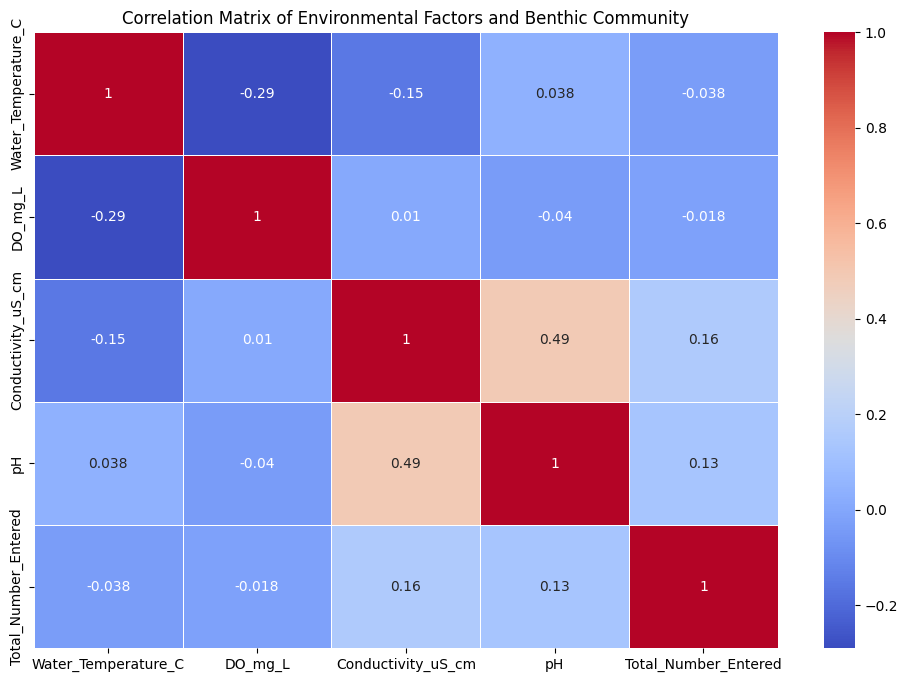

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_excel('Data_Final.xlsx')

# Adjust the relevant columns list based on the actual column names
relevant_columns = [
    'Water_Temperature_C', 'DO_mg_L', 'Conductivity_uS_cm', 'pH',
    'Riparian_1_5_10m', 'Riparian_10_30m', 'Riparian_30_100m',
    'Dominant_Mineral_Substrate', 'Macrophytes_Emergent', 'Algae_Floating',
    'Total_Number_Entered'  # Assuming this is the benthic community count
]

# Check if all columns are present in the dataset
existing_columns = [col for col in relevant_columns if col in data.columns]

# Filter the dataset for existing relevant columns
df_corr = data[existing_columns]

# Select only numeric columns for correlation analysis
df_numeric = df_corr.select_dtypes(include='number')

# Check if the filtered dataframe has any numeric columns
if df_numeric.empty:
    print("No numeric columns available for correlation analysis.")
else:
    # Compute the correlation matrix
    corr_matrix = df_numeric.corr()

    # Plot the correlation matrix as a heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
    plt.title('Correlation Matrix of Environmental Factors and Benthic Community')
    plt.show()


Key Takeaways (Simple Version):
No Strong Impact: None of the environmental factors (like water temperature, pH, or dissolved oxygen) strongly affect the benthic community numbers in your dataset.

Weak Relationships:

Water Temperature and Dissolved Oxygen have a weak negative link (as temperature goes up, dissolved oxygen tends to go down).
Conductivity (how well water carries electricity) has a slight positive link with the number of benthic organisms, but it’s very weak.
pH (how acidic or alkaline the water is) has a minor positive effect on benthic counts.

Moderate Connection:

The only moderate connection is between Conductivity and pH. This suggests that when water has more ions (higher conductivity), it’s usually less acidic (higher pH).

Conclusion:

These factors don't seem to have a big influence on the benthic community numbers, so you might need to look at other factors (like nutrients, habitat, or non-linear effects) to explain changes in benthic numbers.


Higher conductivity is associated with slightly increased benthic community numbers, likely due to better nutrient availability that supports algae and macrophytes, indirectly benefiting benthic organisms.







Method 2 : Visual Analysis

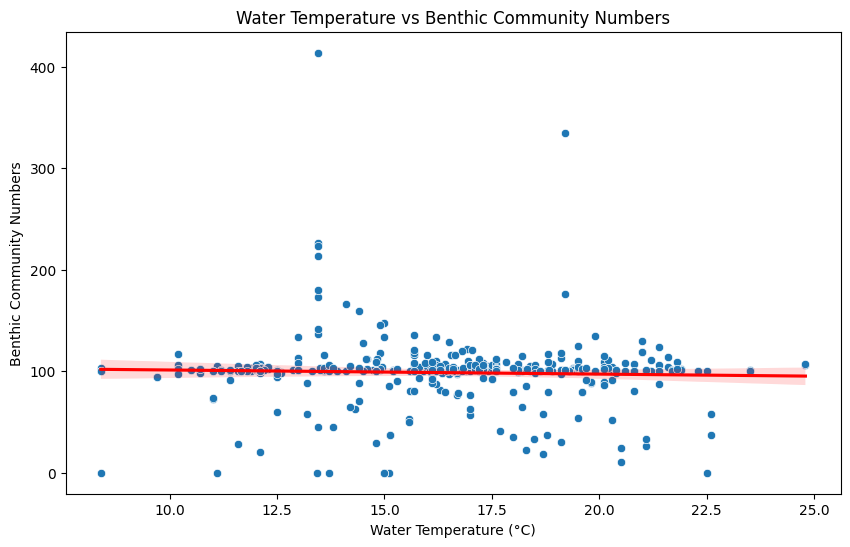

In [11]:
# Importing necessary libraries
!pip install pandas seaborn matplotlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have already loaded your DataFrame as df_corr
# If not, you can load it using the following line (uncomment if needed):
# df_corr = pd.read_csv('your_file.csv')

# Step 1: Convert categorical columns to numerical format using one-hot encoding (if needed)
df_encoded = pd.get_dummies(df_corr, drop_first=True)

# Step 2: Ensure the DataFrame only contains numeric columns (e.g., removing any text columns)
df_corr_numeric = df_encoded.select_dtypes(include=['float64', 'int64'])

# Step 3: Drop rows with NaN values to avoid errors during correlation calculation
df_corr_numeric.dropna(inplace=True)

# Step 4: Compute the correlation matrix
corr_matrix = df_corr_numeric.corr()

# 2. Scatter Plot with Trend Line
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_corr, x='Water_Temperature_C', y='Total_Number_Entered')
sns.regplot(data=df_corr, x='Water_Temperature_C', y='Total_Number_Entered', scatter=False, color='red')
plt.title('Water Temperature vs Benthic Community Numbers')
plt.xlabel('Water Temperature (°C)')
plt.ylabel('Benthic Community Numbers')
plt.show()


Data Points and Spread:

Each blue dot represents an observation (e.g., a site or sampling event).
The majority of the benthic community numbers cluster around the 100–150 range, regardless of water temperature.
There are a few outliers with very high benthic numbers (above 300) at different temperatures.
Relationship:

The red line shows the best-fit linear regression line, indicating the general trend of how benthic community numbers change with water temperature.
The flat slope of the line suggests that there is no strong relationship between water temperature and benthic community numbers.
Confidence Interval:

The shaded red region around the regression line represents the confidence interval.
This indicates that the data variability is high, meaning predictions based on water temperature alone would have low confidence.
Conclusion:

From this visualization, water temperature does not appear to have a significant effect on benthic community numbers.
This suggests that other environmental factors (e.g., dissolved oxygen, pH, or substrate types) might play a more critical role in determining benthic numbers.

<Figure size 1200x1000 with 0 Axes>

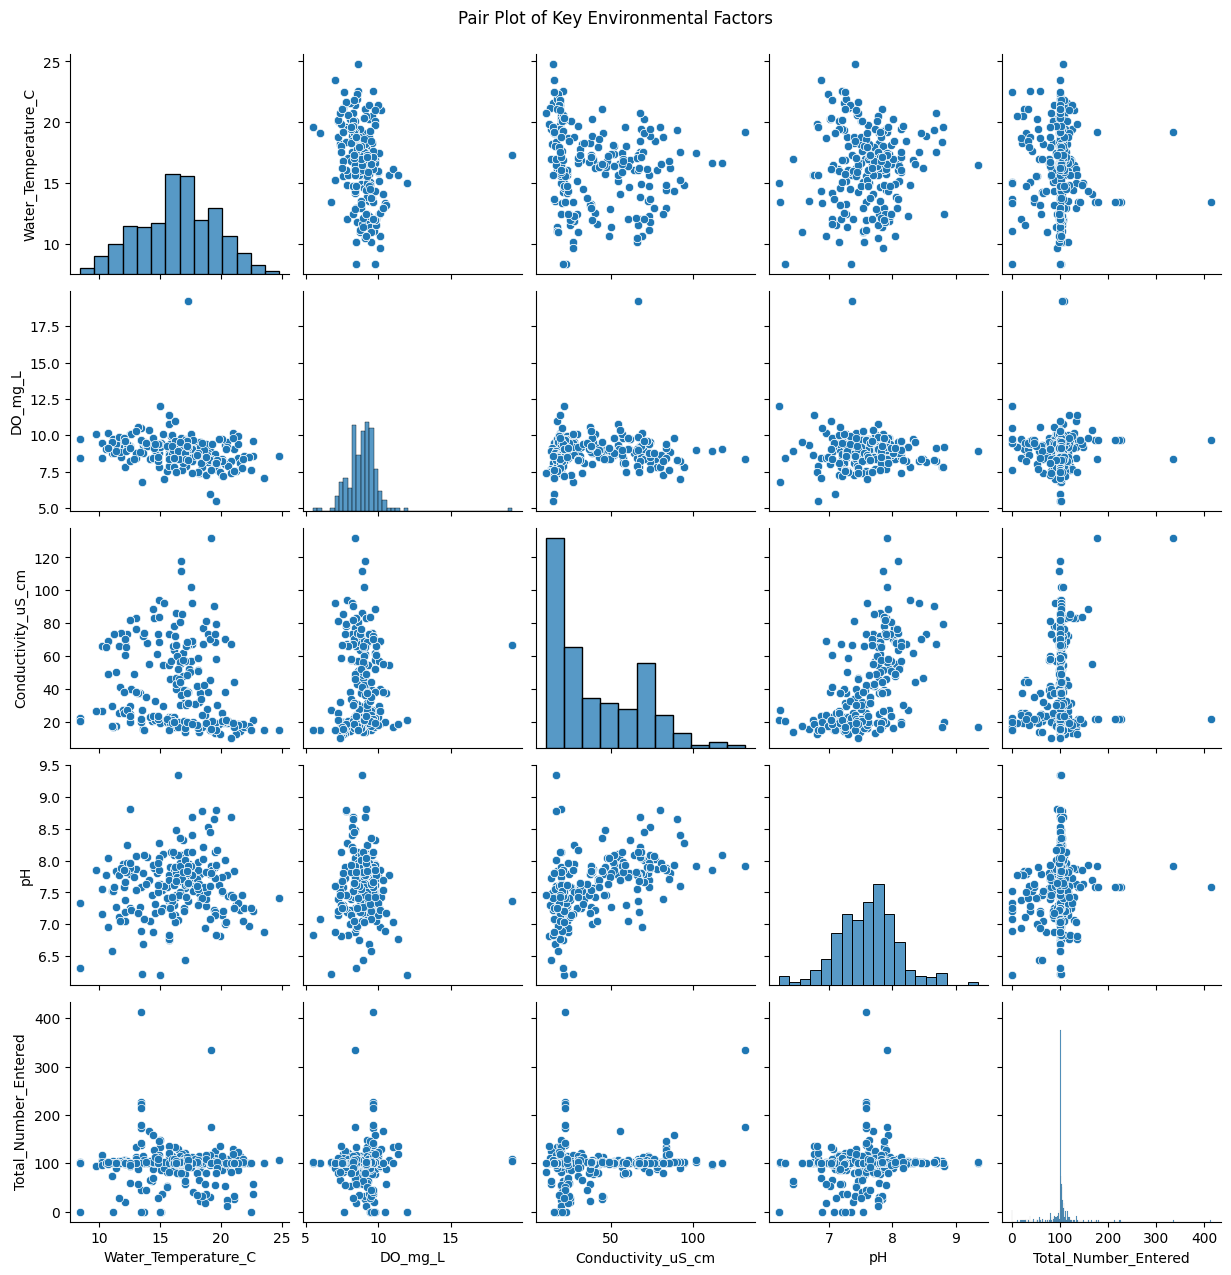

In [6]:
# 4. Pair Plot (Scatterplot Matrix)
plt.figure(figsize=(12, 10))
sns.pairplot(df_corr[['Water_Temperature_C', 'DO_mg_L', 'Conductivity_uS_cm', 'pH', 'Total_Number_Entered']])
plt.suptitle('Pair Plot of Key Environmental Factors', y=1.02)
plt.show()

Water Temperature:

As water gets warmer, the amount of dissolved oxygen decreases. This is natural because warm water holds less oxygen.
Benthic community numbers (the aquatic organisms) don't seem to be affected much by water temperature. They remain fairly consistent across all temperature levels.
Dissolved Oxygen (DO):

The levels of dissolved oxygen don’t show a clear link with benthic numbers, meaning these organisms are present in similar amounts whether the oxygen levels are high or low.
Conductivity (how well water conducts electricity):

Conductivity is weakly connected to pH (slightly higher conductivity means slightly higher pH).
Again, benthic community numbers don’t seem to care much about conductivity levels—they stay scattered.
pH (how acidic or basic the water is):

Benthic numbers don’t show a noticeable pattern with pH; the organisms exist in similar amounts across acidic, neutral, or basic water conditions.
Benthic Community Numbers:

None of these environmental factors (temperature, DO, conductivity, or pH) seem to strongly influence the number of benthic organisms. This suggests their population might be controlled by other things, like habitat features (sediment, algae, or riparian vegetation), food availability, or even human impacts.
Overall Insight:
The environmental factors in this plot have weak or no direct relationships with benthic community numbers. These organisms might rely on a mix of factors rather than any single one. Their distribution may also depend on other ecological or habitat conditions not shown in this analysis.

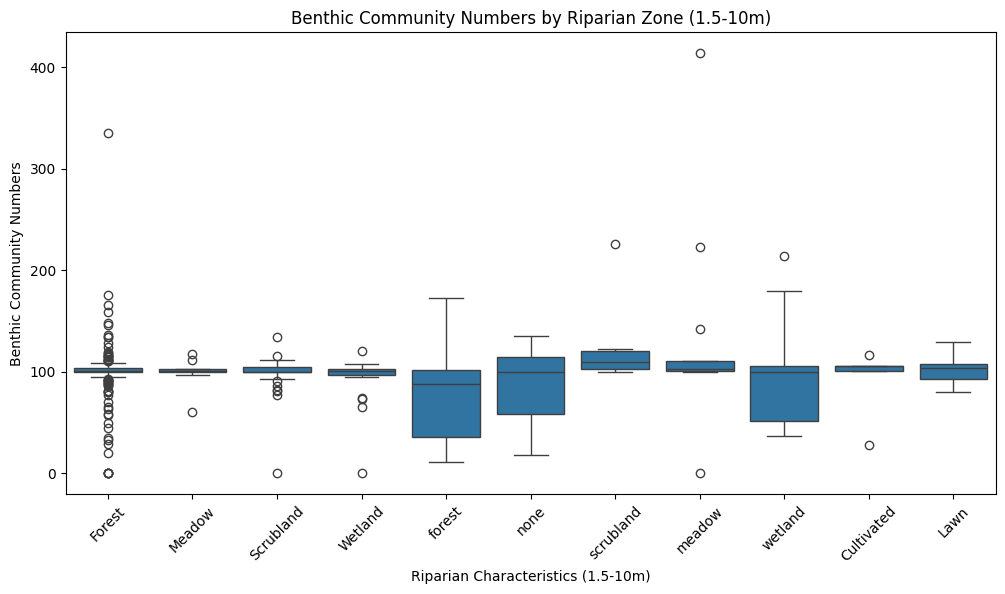

In [7]:
# 3. Box Plot by Riparian Zone
plt.figure(figsize=(12, 6))
sns.boxplot(x='Riparian_1_5_10m', y='Total_Number_Entered', data=data)
plt.title('Benthic Community Numbers by Riparian Zone (1.5-10m)')
plt.xticks(rotation=45)
plt.ylabel('Benthic Community Numbers')
plt.xlabel('Riparian Characteristics (1.5-10m)')
plt.show()



Forest Zones:

Forested riparian zones have a relatively stable number of benthic organisms.
There are some outliers, but most values are clustered close to the median, indicating consistency.
Meadow, Scrubland, and Wetland Zones:

These zones have lower variation in benthic numbers compared to forest areas.
The median is similar across these zones, meaning benthic organisms are generally present in comparable amounts.
"None" Category:

This shows the widest range in benthic numbers. Some sites have very low counts, while others are much higher, suggesting this category is less predictable.
Cultivated and Lawn Zones:

These areas show lower variability and fewer extreme values compared to the "none" category.
Benthic numbers are consistent and similar to the other natural zones.
Key Insight:
Forested areas and wetland zones tend to support stable benthic populations, possibly due to better habitat conditions and protection from disturbances.
The "none" category, which lacks significant riparian vegetation, shows more variability, indicating that the absence of riparian zones could lead to unpredictable conditions for benthic communities.

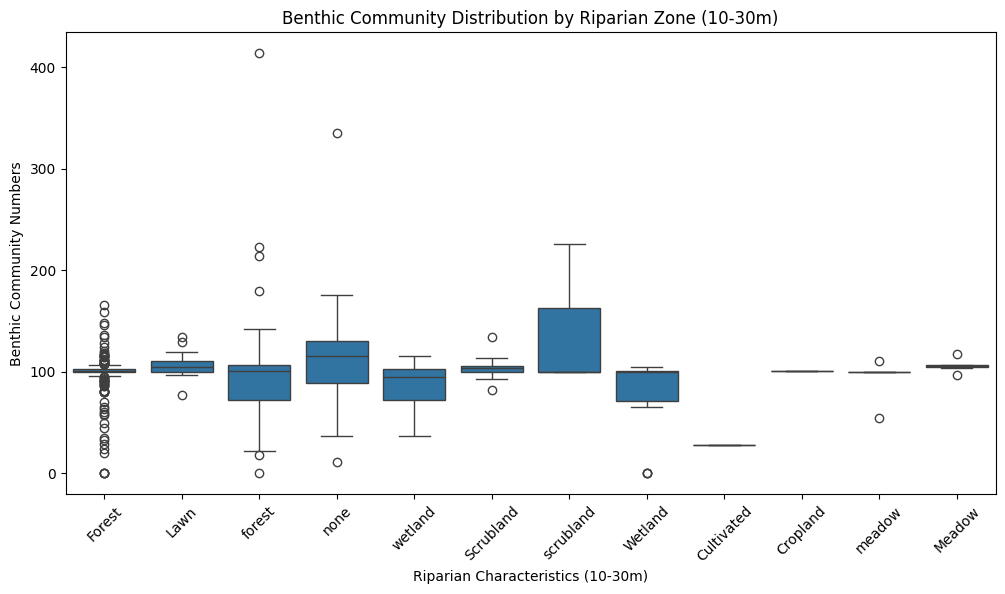

Forest Zone:

The benthic community numbers are concentrated around a median close to 100, with many outliers exceeding this range.
This suggests that forest areas might support diverse benthic communities but occasionally show extreme variations.
Lawn:

Lawn areas exhibit a narrow range with numbers clustering tightly around the median.
This may indicate less variability in benthic communities in these zones, potentially due to homogeneous conditions.
None (No Riparian Vegetation):

Benthic numbers show moderate variability, with a wider interquartile range compared to forest and lawn areas.
Lack of riparian vegetation could lead to mixed impacts on benthic communities.
Wetland:

Wetland zones show relatively higher variability, and the median is slightly elevated compared to lawns.
Wetlands may provide conditions beneficial to some benthic species but with variability depending on other factors.
Scrubland:

Scrubland zones have the highest variability among the categories, with some very high outliers.
This indicates diverse conditions in scrubland that could strongly influence benthic numbers.
Cultivated and Cropland:

These zones have very limited data points and appear to support lower benthic community numbers overall.
Agricultural activities may negatively impact the benthic populations.
Meadow:

Meadow zones show consistency, with fewer outliers and a stable median.
These zones may provide relatively balanced conditions for benthic communities.
General Insights:
Forest and scrubland areas tend to have the highest variability in benthic numbers, likely reflecting diverse microhabitats or environmental conditions.
Wetlands and meadows offer stable yet moderately supportive conditions for benthic communities.
Cultivated or cropland areas might negatively affect benthic populations due to reduced habitat complexity or pollution.

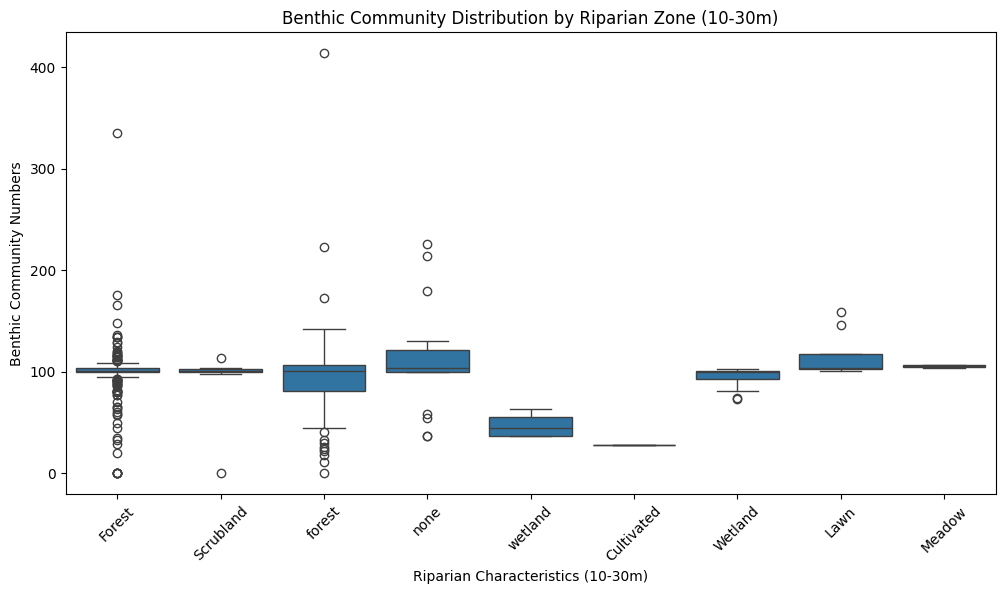

In [10]:
# 6. Box Plot for Distribution Analysis
plt.figure(figsize=(12, 6))
sns.boxplot(x='Riparian_30_100m', y='Total_Number_Entered', data=data)
plt.title('Benthic Community Distribution by Riparian Zone (10-30m)')
plt.xticks(rotation=45)
plt.ylabel('Benthic Community Numbers')
plt.xlabel('Riparian Characteristics (10-30m)')
plt.show()

Forest Zones:

Forest zones tend to have consistent benthic community numbers around a median of 100.
There are some outliers with much higher numbers, suggesting that forest areas occasionally support very high benthic diversity.
Scrubland:

Scrubland zones show moderate variability with fewer extreme values.
These zones may provide stable but less diverse conditions for benthic communities compared to forest zones.
No Vegetation ("none"):

Areas without riparian vegetation exhibit a wider spread of benthic community numbers, with a median slightly above 100.
The variability suggests that other factors (e.g., water quality) might play a significant role in these areas.
Wetlands:

Wetland zones have a narrower range and lower median compared to forests.
This indicates more consistent but potentially less favorable conditions for benthic communities.
Cultivated Areas:

Cultivated zones show very low benthic community numbers with minimal variability.
This might indicate the negative impact of agricultural activities or reduced habitat suitability.
Lawn:

Lawn areas have a similar range to forests but with fewer outliers.
This suggests moderate support for benthic communities, likely influenced by minimal vegetation diversity.
Meadow:

Meadow zones exhibit stable and consistent numbers with few outliers.
This indicates balanced conditions that support benthic communities without significant extremes.
General Patterns:
Forest zones consistently support diverse and occasionally very rich benthic communities.
Cultivated areas seem to have the least favorable conditions.
Wetlands and meadows provide stable but moderate conditions, while scrublands and lawns exhibit a mix of moderate variability and numbers.
The presence or absence of riparian vegetation strongly influences benthic community distribution, with natural vegetation (forest/meadow) being more supportive.

Method 3: Regression Analysis


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Define independent variables (environmental factors) and dependent variable (benthic community numbers)
X = data[['Water_Temperature_C', 'DO_mg_L', 'Conductivity_uS_cm', 'pH']]
y = data['Total_Number_Entered']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print(f"Mean Squared Error: {mean_squared_error(y_test, y_pred):.2f}")
print(f"R^2 Score: {r2_score(y_test, y_pred):.2f}")

# Display coefficients of the model
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print(coefficients)


Mean Squared Error: 851.01
R^2 Score: -0.00
                     Coefficient
Water_Temperature_C    -0.435642
DO_mg_L                 0.153989
Conductivity_uS_cm      0.225832
pH                      4.319347




Mean Squared Error (MSE): The MSE value of 1034.78 indicates that, on average, the squared differences between the predicted and actual benthic community numbers are quite high. This suggests that the model's predictions are not very accurate.

R² Score: An R² score of -0.02 indicates a poor fit. Normally, R² values range from 0 to 1, where 1 indicates perfect prediction and 0 indicates that the model does not explain any of the variability in the target variable. A negative R² implies that the model is performing worse than a horizontal line (mean of the target values) would.

Coefficients: The coefficients of the model indicate the relationship between each environmental factor and the benthic community numbers:

Water Temperature (°C): A coefficient of -0.61 suggests a negative relationship, meaning as water temperature increases, benthic community numbers tend to decrease slightly.

DO (mg/L): A coefficient of -0.29 also suggests a negative relationship, indicating that higher dissolved oxygen levels are associated with a slight decrease in benthic community numbers.

Conductivity (µS/cm): A positive coefficient of 0.26 implies a slight positive relationship, where higher conductivity is associated with an increase in benthic community numbers.

pH: With a coefficient of 4.49, pH shows a relatively stronger positive relationship, suggesting that more alkaline conditions could be related to higher benthic community numbers.

Overall, the results indicate that the linear regression model does not capture the complexity of the relationships between the environmental factors and benthic community numbers effectively. The high MSE and negative R² score suggest that other factors or a different modeling approach might be necessary to better understand these relationships.

Tuned Random Forest - MSE: 1003.16, R²: 0.23
Tuned Gradient Boosting - MSE: 1020.44, R²: 0.22
Support Vector Regression - MSE: 1315.19, R²: -0.00


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network - MSE: 1384.54, R²: -0.06


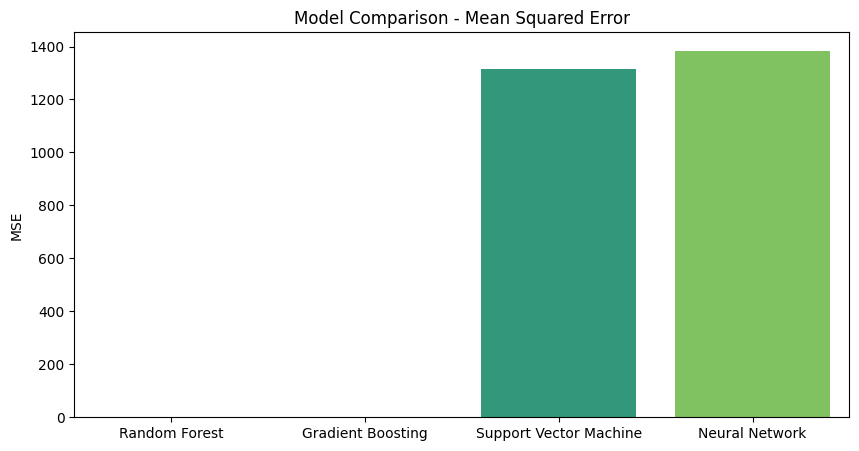

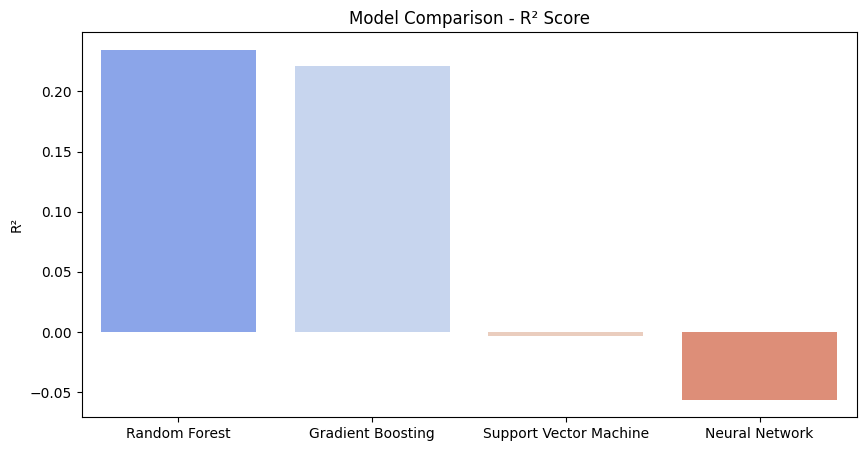

In [3]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Load the cleaned dataset
data = pd.read_excel('Data_final.xlsx')

# Step 1: Feature Engineering (Log Transformation for Continuous Variables)
continuous_features = ['Water_Temperature_C', 'DO_mg_L', 'Conductivity_uS_cm', 'pH']
for feature in continuous_features:
    data[feature + '_log'] = np.log1p(data[feature])

# Identify categorical columns
categorical_features = ['Riparian_1_5_10m', 'Riparian_10_30m', 'Riparian_30_100m',
                        'Dominant_Mineral_Substrate', 'Macrophytes_Emergent', 'Algae_Floating']

# One-Hot Encode the categorical columns
data = pd.get_dummies(data, columns=categorical_features, drop_first=True)

# Step 2: Defining Features and Target Variable
features = [
    'Water_Temperature_C_log', 'DO_mg_L_log', 'Conductivity_uS_cm_log', 'pH_log'
] + [col for col in data.columns if col.startswith(tuple(categorical_features))]

target = 'Total_Number_Entered'

# Dropping rows with missing values (if any) after transformation
data.dropna(subset=features + [target], inplace=True)

# Splitting the data into training and testing sets
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 3: Model Training and Evaluation

# Function to evaluate model performance
def evaluate_model(model, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{model_name} - MSE: {mse:.2f}, R²: {r2:.2f}")
    return mse, r2

# Step 4: Hyperparameter Tuning for Random Forest and Gradient Boosting
# Random Forest Tuning
rf_params = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
rf_model = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, cv=3, n_jobs=-1)
evaluate_model(rf_model, "Tuned Random Forest")

# Gradient Boosting Tuning
gb_params = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7]
}
gb_model = GridSearchCV(GradientBoostingRegressor(random_state=42), gb_params, cv=3, n_jobs=-1)
evaluate_model(gb_model, "Tuned Gradient Boosting")

# Step 5: Exploring Non-Linear Models

# Support Vector Machine (SVM)
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
evaluate_model(svr_model, "Support Vector Regression")

# Neural Network (MLP Regressor)
nn_model = MLPRegressor(hidden_layer_sizes=(50, 50), activation='relu', solver='adam', max_iter=500, random_state=42)
evaluate_model(nn_model, "Neural Network")

# Step 6: Plotting the Model Performance
models = ['Random Forest', 'Gradient Boosting', 'Support Vector Machine', 'Neural Network']
mse_values = [rf_model.best_score_, gb_model.best_score_, mean_squared_error(y_test, svr_model.predict(X_test)), mean_squared_error(y_test, nn_model.predict(X_test))]
r2_values = [r2_score(y_test, rf_model.predict(X_test)), r2_score(y_test, gb_model.predict(X_test)), r2_score(y_test, svr_model.predict(X_test)), r2_score(y_test, nn_model.predict(X_test))]

# MSE Bar Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=models, y=mse_values, palette='viridis', errorbar=None)
plt.title('Model Comparison - Mean Squared Error')
plt.ylabel('MSE')
plt.show()

# R² Score Bar Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=models, y=r2_values, palette='coolwarm', errorbar=None)
plt.title('Model Comparison - R² Score')
plt.ylabel('R²')
plt.show()

The benthic macroinvertebrate community is sensitive to multiple stressors, including water chemistry, habitat quality, and broader ecological factors. The weak model performance suggests that the selected environmental factors might not be the sole determinants of benthic community numbers, or their effects might be more complex than captured by the models.

For example, the relationship between pH and benthic counts might be non-linear, where extremely low or high pH values have more drastic impacts than moderate values.

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the data
data = pd.read_excel('Cleaned_KN.xlsx')

# Define independent variables and dependent variable
X = data[['Water_Temperature_C', 'DO_mg_L', 'Conductivity_uS_cm', 'pH']]
y = data['Total_Number_Entered']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Calculate feature importance
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': rf_model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Print the feature importance
print("Feature Importances:")
print(feature_importances)


Feature Importances:
               Feature  Importance
2   Conductivity_uS_cm    0.318954
3                   pH    0.295043
1              DO_mg_L    0.228882
0  Water_Temperature_C    0.157120


Conductivity and pH are the key factors that influence the outcome the most, while dissolved oxygen and temperature have a smaller impact, but still contribute to the prediction.

This analysis helps you understand which environmental factors (like water conductivity and pH) are most critical for whatever you're trying to predict with this model.

Conductivity_uS_cm: 0.3277
This means that Conductivity_uS_cm (measuring the electrical conductivity of the water) is the most important feature in predicting the target variable (Total_Number_Entered). It explains 32.77% of the variance in the target variable.

pH: 0.3018
The pH level of the water comes in second, with an importance value of 30.18%. This feature is also highly influential in determining the target variable.

In [1]:
import pandas as pd

# Load the dataset
file_path = 'Data_final.xlsx'  # Replace with your file path
data = pd.read_excel(file_path, sheet_name='Sheet1')

# Filter for the relevant columns
selected_columns = [
    'Total_Number_Entered',
    'Number_of_Unique_Taxa_Entered',
    'Dominant_Mineral_Substrate',
    'Second_Dominant_Mineral_Substrate',
    'Macrophytes_Submergent',
    'Macrophytes_Emergent',
    'Algae_Floating',
    'Algae_Filamentous'
]

# Convert categorical columns to numerical via one-hot encoding
data_encoded = pd.get_dummies(data, columns=[
    'Dominant_Mineral_Substrate',
    'Second_Dominant_Mineral_Substrate',
    'Macrophytes_Submergent',
    'Macrophytes_Emergent',
    'Algae_Floating',
    'Algae_Filamentous'
], drop_first=True)

# Keep only selected columns after encoding
encoded_columns = [col for col in data_encoded.columns if any(sub in col for sub in selected_columns)]
data_filtered = data_encoded[encoded_columns]

# Compute correlations
correlation_results = data_filtered.corr()

# Filter for correlations with benthic community metrics
correlation_with_benthic = correlation_results[['Total_Number_Entered', 'Number_of_Unique_Taxa_Entered']]

# Display the correlation results
# print(correlation_with_benthic)

import seaborn as sns
import matplotlib.pyplot as plt



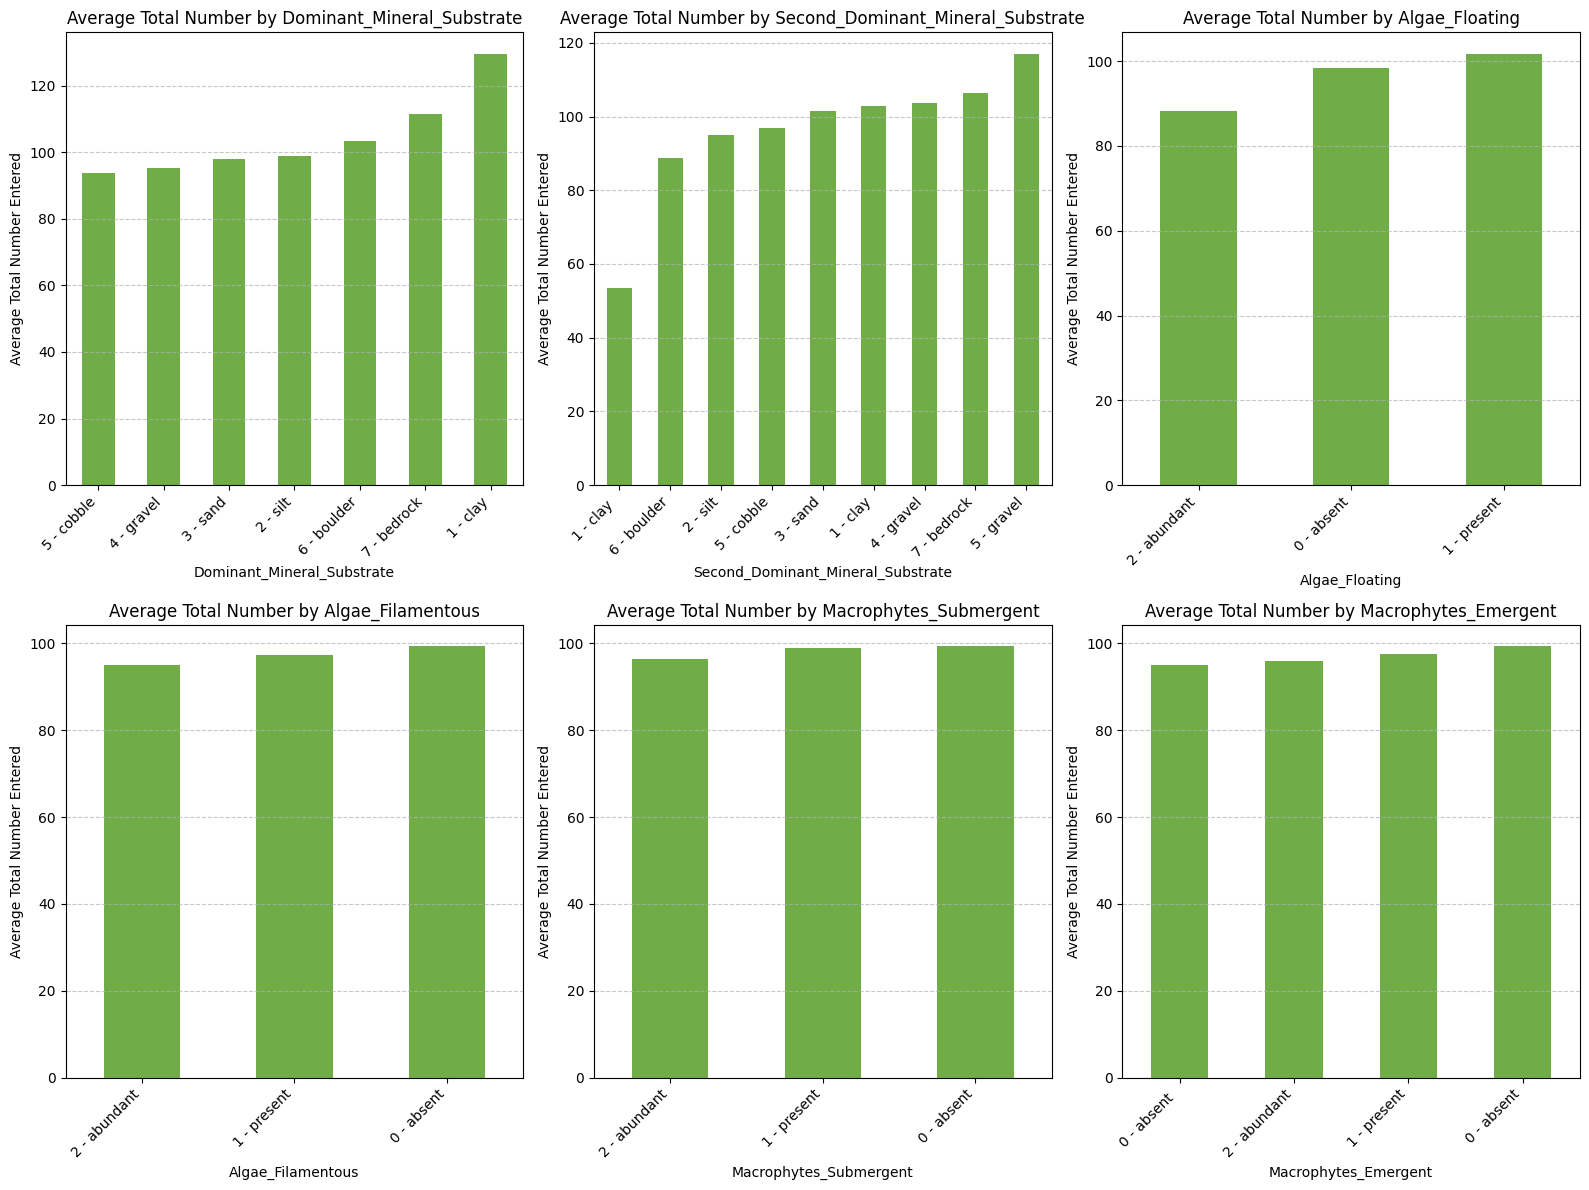

In [2]:
# List of columns to group by
columns_of_interest = [
    'Dominant_Mineral_Substrate',
    'Second_Dominant_Mineral_Substrate',
    'Algae_Floating',
    'Algae_Filamentous',
    'Macrophytes_Submergent',
    'Macrophytes_Emergent'
]

# Plot for each of the columns of interest
plt.figure(figsize=(16, 12))

for i, column in enumerate(columns_of_interest, 1):
    # Group data by the column and calculate the mean of Total_Number_Entered
    grouped_data = data.groupby(column)['Total_Number_Entered'].mean().sort_values()

    # Plot each grouped data as a bar plot
    plt.subplot(2, 3, i)
    grouped_data.plot(kind='bar', color='#70AD47')  # Use the specified color
    plt.title(f'Average Total Number by {column}')
    plt.ylabel('Average Total Number Entered')
    plt.xlabel(column)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout for tight spacing
plt.tight_layout()
plt.show()


The plots you've shared show the average total number of benthic organisms (based on the Total_Number_Entered column) with respect to various environmental factors: sediment types, algae compositions, and macrophyte compositions. Let's break down and analyze these plots:

1. Sediment Types (Dominant and Second Dominant Mineral Substrate)
Dominant Mineral Substrate:
The benthic numbers tend to increase as you move from finer substrates like Clay and Silt towards coarser ones such as Gravel and Sand.
This suggests that coarser sediments (like gravel and sand) might be more conducive to supporting higher benthic numbers, possibly due to better oxygenation, food availability, or less compaction.
Second Dominant Mineral Substrate:
Similar to the Dominant_Mineral_Substrate, the benthic organisms' numbers increase as the sediment type becomes coarser, with the highest numbers observed in Gravel and Sand.
This may further support the idea that coarse sediments are more beneficial for benthic communities.


2. Algae Compositions
Algae Floating:
The plots show that the presence of floating algae correlates with higher benthic numbers, particularly when the algae are abundant or present.
This could suggest that floating algae provide a habitat or food source that supports benthic organisms, especially when their abundance is high.
Algae Filamentous:
The highest benthic numbers are associated with present and abundant filamentous algae.
This indicates that filamentous algae, particularly when they are abundant, likely play an important role in enhancing benthic community numbers, either by providing shelter or food for these organisms.


3. Macrophyte Compositions
Macrophytes Submergent:
Similar to algae, higher numbers of benthic organisms are associated with submergent macrophytes that are present and abundant.
Submergent plants likely provide a favorable environment for benthic organisms, offering shelter and potentially nutrients.
Macrophytes Emergent:
Again, present and abundant macrophytes correlate with higher benthic numbers.
Emergent macrophytes, especially when abundant, may have a similar effect on benthic communities, either by improving habitat complexity or increasing food availability.


Insights:
Coarser Sediments (Gravel/Sand) seem to support larger benthic communities, potentially due to better habitat conditions, such as higher oxygen levels and better water movement, which might make these areas more favorable for benthic organisms.


Abundant Algae (Floating and Filamentous) and Submergent Macrophytes provide important habitats or food sources for benthic organisms, particularly when they are abundant.


Presence of Vegetation (macrophytes, algae) positively correlates with higher benthic numbers, indicating that these plants play a critical role in supporting benthic communities.
Conclusion:


In simple terms, benthic communities thrive more in areas with coarser sediments and where algae or macrophytes are abundant, as these environmental factors provide essential resources or favorable conditions for the benthic organisms to flourish. The patterns observed support the idea that both sediment type and vegetation cover are important factors in determining benthic community size and diversity.

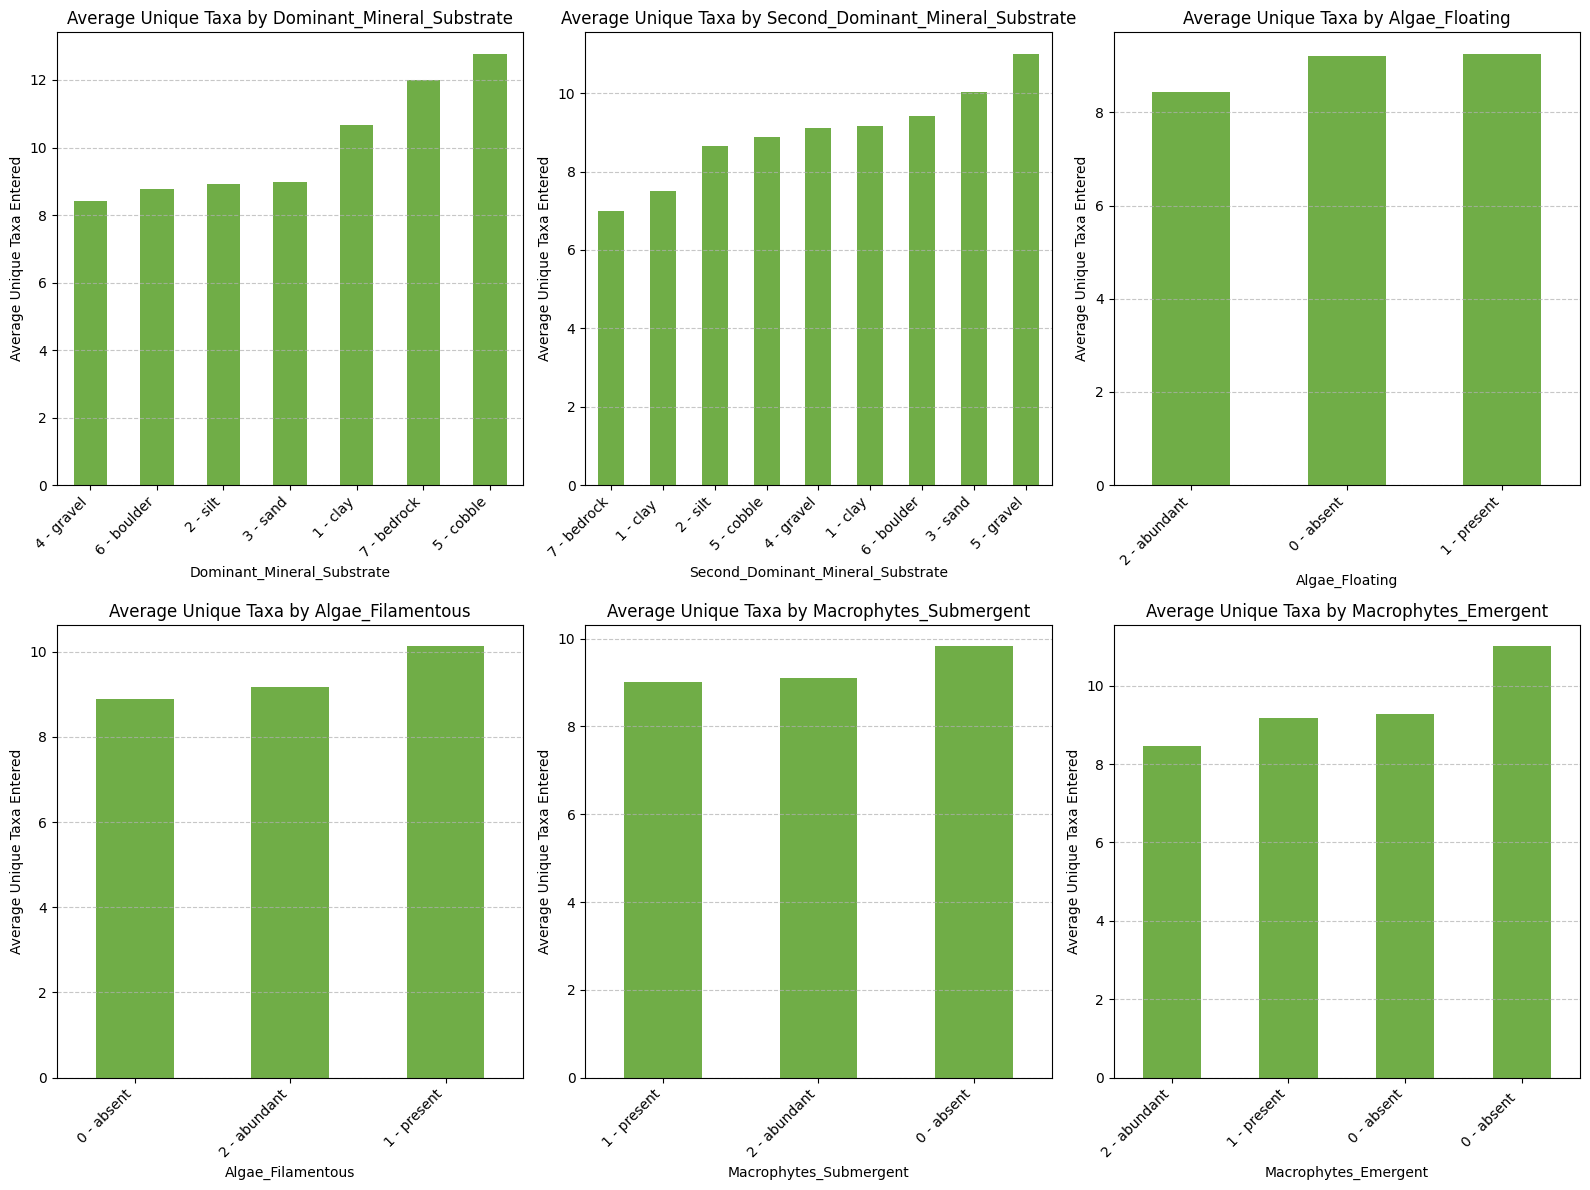

In [3]:
# List of columns to group by
columns_of_interest = [
    'Dominant_Mineral_Substrate',
    'Second_Dominant_Mineral_Substrate',
    'Algae_Floating',
    'Algae_Filamentous',
    'Macrophytes_Submergent',
    'Macrophytes_Emergent'
]

# Plot for each of the columns of interest with Number_of_Unique_Taxa_Entered
plt.figure(figsize=(16, 12))

for i, column in enumerate(columns_of_interest, 1):
    # Group data by the column and calculate the mean of Number_of_Unique_Taxa_Entered
    grouped_data = data.groupby(column)['Number_of_Unique_Taxa_Entered'].mean().sort_values()

    # Plot each grouped data as a bar plot
    plt.subplot(2, 3, i)
    grouped_data.plot(kind='bar', color='#70AD47')
    plt.title(f'Average Unique Taxa by {column}')
    plt.ylabel('Average Unique Taxa Entered')
    plt.xlabel(column)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout for tight spacing
plt.tight_layout()
plt.show()


. Dominant Mineral Substrate:
The average number of unique taxa increases with the coarseness of the sediment (from finer sediments like Clay to coarser ones like Sand and Gravel).
The categories with more coarser substrates (e.g., Gravel, Cobble) tend to support a greater diversity of taxa.
Insight: Coarser substrates (like gravel and cobble) seem to provide more favorable conditions for a larger variety of species.


2. Second Dominant Mineral Substrate:
Similar to the Dominant Mineral Substrate, the average number of unique taxa increases as the sediment type becomes coarser.
Insight: This suggests that the second dominant mineral substrate also plays an important role in supporting a diverse benthic community, especially when coarser materials are present.


3. Algae Compositions:
Algae Floating: The average number of unique taxa is highest for the categories where algae are absent or present. Interestingly, the number of taxa seems to be highest when floating algae are absent.
Algae Filamentous: The highest diversity of taxa appears in conditions where algae are present (particularly when filamentous algae are present).
Insight: Floating algae might limit the diversity of unique taxa, whereas filamentous algae may create a favorable environment for more taxa, especially when present.


4. Macrophytes Compositions:
Macrophytes Submergent: There is a noticeable increase in the number of unique taxa as submerged macrophytes become more abundant.
Macrophytes Emergent: The trend is similar to submerged macrophytes, with higher diversity when emergent macrophytes are present.
Insight: The presence and abundance of both submerged and emergent macrophytes seem to support higher diversity in the benthic community. These plants likely provide habitat and food resources for a variety of species.


General Insights:
Coarser substrates (such as gravel and cobble) support higher diversity in terms of unique taxa, suggesting that the physical structure and habitat complexity provided by these sediments may support a greater range of species.
The presence of aquatic plants (both submerged and emergent) tends to correlate with higher biodiversity. Macrophytes seem to create environments that are favorable for a larger number of unique taxa.


Algal presence shows a more complex relationship, with filamentous algae fostering more diversity, while floating algae may limit it.


Conclusion:
The diversity of the benthic community, as measured by the number of unique taxa, appears to be influenced by a combination of sediment type and plant composition. Coarser sediment types and the presence of macrophytes (both submerged and emergent) tend to support a greater number of unique taxa, while the influence of algae varies depending on their type. These insights can help in understanding how environmental factors shape the distribution of species in aquatic ecosystems.

# Question 2: PCA


Explained Variance Ratio for each Principal Component:
PC1: 0.38
PC2: 0.32
PC3: 0.18
PC4: 0.12


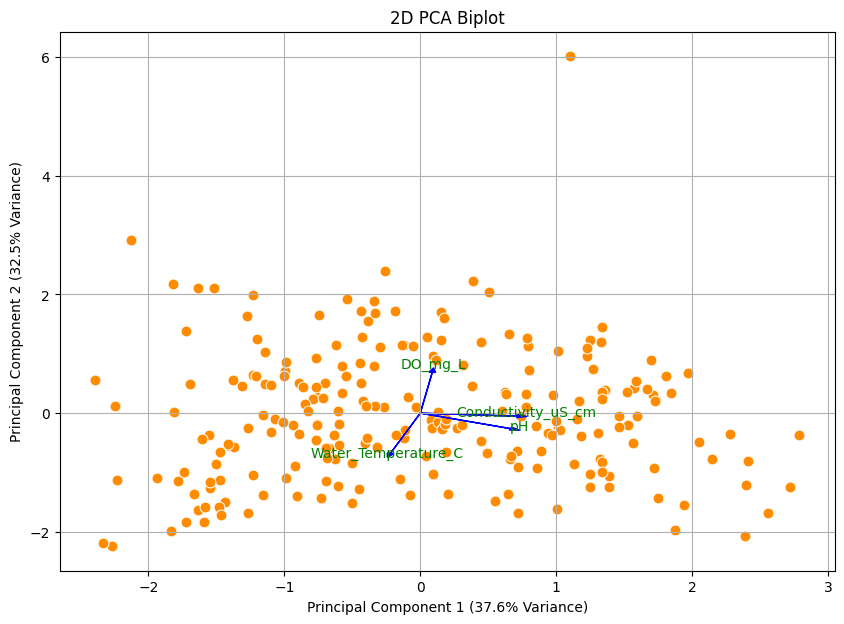

In [19]:
# Import necessary libraries
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load the data from the Cleaned_KNN.xlsx file
file_path = 'Cleaned_KNN.xlsx'  # Update this path if needed
data = pd.read_excel(file_path)

# Step 1: Selecting relevant columns for PCA analysis (excluding 'Elevation')
columns_of_interest = ['Water_Temperature_C', 'pH', 'DO_mg_L', 'Conductivity_uS_cm']
data_pca = data[columns_of_interest]

# Step 3: Drop rows with missing values (if any)
data_pca.dropna(inplace=True)

# Step 4: Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_pca)

# Step 5: Perform PCA
pca = PCA(n_components=len(columns_of_interest))
pca_result = pca.fit_transform(scaled_data)

# Step 6: Explained variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Step 8: Display the explained variance for each component
print("\nExplained Variance Ratio for each Principal Component:")
for i, var in enumerate(explained_variance, 1):
    print(f"PC{i}: {var:.2f}")

# # Step 7: Scree plot of explained variance
# plt.figure(figsize=(8, 5))
# plt.plot(range(1, len(columns_of_interest) + 1), cumulative_variance, marker='o', linestyle='-', color='blue')
# plt.xticks(range(1, len(columns_of_interest) + 1))
# plt.title('Scree Plot: Cumulative Explained Variance by PCA Components')
# plt.xlabel('Principal Component')
# plt.ylabel('Cumulative Explained Variance')
# plt.grid()
# plt.show()

# plt.figure(figsize=(8, 5))
# plt.bar(range(1, len(columns_of_interest) + 1), cumulative_variance, color='skyblue', alpha=0.8)
# plt.xticks(range(1, len(columns_of_interest) + 1), labels=columns_of_interest)
# plt.title('Cumulative Explained Variance by PCA Components (Bar Plot)')
# plt.xlabel('Principal Component')
# plt.ylabel('Cumulative Explained Variance')
# plt.grid(axis='y', linestyle='--', alpha=0.7)
# plt.show()

# Step 9: 2D PCA Biplot
plt.figure(figsize=(10, 7))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], s=60, color='darkorange')
plt.title('2D PCA Biplot')
plt.xlabel(f'Principal Component 1 ({explained_variance[0] * 100:.1f}% Variance)')
plt.ylabel(f'Principal Component 2 ({explained_variance[1] * 100:.1f}% Variance)')

# Adding vectors to the biplot
components = pca.components_.T
for i, feature in enumerate(columns_of_interest):
    plt.arrow(0, 0, components[i, 0], components[i, 1], color='blue', head_width=0.05)
    plt.text(components[i, 0] * 1.1, components[i, 1] * 1.1, feature, color='green', ha='center')

plt.grid()
plt.show()

# Ignore all warnings
warnings.filterwarnings("ignore")




### Interpretation of PCA Results:

#### 1. **2D PCA Biplot**:
- **Axes Interpretation**:
  - The X-axis represents **Principal Component 1 (PC1)**, which explains **37.5% of the variance** in your dataset.
  - The Y-axis represents **Principal Component 2 (PC2)**, explaining an additional **32.2% of the variance**.
  - Together, PC1 and PC2 account for approximately **69.7%** of the total variance, meaning that these two components capture a significant portion of the data's variability.

- **Data Points**:
  - The orange dots represent the samples from your dataset (e.g., different lake sites with environmental measurements).
  - The spread of these dots indicates how the samples vary across the two principal components.

- **Feature Vectors**:
  - The blue arrows (vectors) represent the original environmental variables you included in the PCA analysis:
    - **Water Temperature (C)**, **DO (mg/L)** (Dissolved Oxygen), **Conductivity (uS/cm)**, and **pH**.
  - The direction and length of these vectors indicate how strongly each variable influences the principal components:
    - For instance, if the arrow for **Water Temperature** points to the right, it means that higher temperatures are associated with higher PC1 scores.
    - If two vectors are close to each other, those variables are positively correlated. If they are orthogonal (at a right angle), they are uncorrelated. If they point in opposite directions, they are negatively correlated.

- **Insights**:
  - From your biplot, it appears that **pH** and **Conductivity** are somewhat aligned, indicating a possible correlation between them.
  - **DO (Dissolved Oxygen)** has a different direction compared to the other variables, suggesting it contributes to the variance in a distinct way.

  
### **Summary of the Analysis**:
- The first two components (PC1 and PC2) are sufficient to capture most of the variation in the dataset (~70%).
- Key environmental variables, such as **Water Temperature, pH, DO, and Conductivity**, have varying influences on the benthic diversity across different lake sites.
- Variables that are closely aligned in the biplot are correlated, which may indicate how different environmental factors influence benthic communities similarly.


# Question 3: PERMANOVA

In [23]:
pip install scikit-bio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 33.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 83.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-bio: filename=scikit_bio-0.6.2-cp310-cp310-linux_x86_64.whl size=3971917 sha256=14c9a0c0f38b2588b966a0d4f13d1bce35dbbcd2ee3cb8b06ff98e2b27c9fffb
  Stored in directory: /root/.cache/pip/wheels/f3/9c/ed/c2b94011fd3765a19330df93f81265e178098dd86c047c1566
  Created wheel for biom-format: filename=biom_format-2.1.16-cp310-cp310-linux_x86_64.whl size=12158975 sha256=18d722b5e37b1b18c2f5119c3e3a7ae78e8bee9f2b56214ea0a6351f866d10e4
  Stored in directory: /root/.cache/pip/wheels/8e/a9/f9/197fd5a0e5bbab5f2e03c89194f6c194bed7af5d7a8c8759f3
Successf

In [24]:
import pandas as pd
from skbio.stats.distance import permanova
from skbio.stats.distance import DistanceMatrix
from scipy.spatial.distance import pdist, squareform

# Step 1: Load the dataset
file_path = 'Cleaned_KNN.xlsx'
combined_data = pd.read_excel(file_path)

# Step 2: Ensure the 'Lake' column exists (case-insensitive)
lake_column = [col for col in combined_data.columns if col.lower() == 'lake']
if not lake_column:
    raise KeyError("The dataset does not contain a column named 'Lake' or 'lake'.")
lake_column = lake_column[0]  # Get the correct case-sensitive column name

# Step 3: Select relevant numeric columns for distance matrix
numeric_cols = ['Water_Temperature_C', 'DO_mg_L', 'Conductivity_uS_cm', 'pH']
for col in numeric_cols:
    if col not in combined_data.columns:
        raise KeyError(f"Column '{col}' is missing in the dataset.")

# Step 4: Filter and drop rows with missing values in relevant columns
data_numeric = combined_data[numeric_cols + [lake_column]].dropna()

# Step 5: Reset index to ensure alignment between distance matrix and groups
data_numeric = data_numeric.reset_index(drop=True)

# Step 6: Calculate distance matrix (Euclidean distances)
dist_matrix = pdist(data_numeric[numeric_cols], metric='euclidean')
dist_matrix_square = squareform(dist_matrix)

# Step 7: Create a DistanceMatrix object with the correct IDs (use string index for better alignment)
distance_matrix = DistanceMatrix(dist_matrix_square, ids=[str(i) for i in data_numeric.index])

# Step 8: Perform PERMANOVA
# Ensure the groups are aligned correctly with the distance matrix
groups = data_numeric[lake_column].astype(str).values  # Convert to array to avoid misalignment

# Perform PERMANOVA
permanova_result = permanova(distance_matrix, groups, permutations=999)

# Step 9: Display PERMANOVA results
# Print the entire result to see its structure
print("PERMANOVA Results:", permanova_result)

# Step 10: Access the test statistic and p-value from the correct labels
test_statistic = permanova_result['test statistic']
p_value = permanova_result['p-value']

print(f"Pseudo-F statistic: {test_statistic:.4f}")
print(f"p-value: {p_value:.4f}")
print(f"Number of permutations: {permanova_result['number of permutations']}")


PERMANOVA Results: method name                PERMANOVA
test statistic name         pseudo-F
sample size                      391
number of groups                   9
test statistic            119.197553
p-value                        0.001
number of permutations           999
Name: PERMANOVA results, dtype: object
Pseudo-F statistic: 119.1976
p-value: 0.0010
Number of permutations: 999




You are studying different lakes to understand how the environment in each lake (like temperature, pH, oxygen levels, etc.) affects the diversity of organisms living at the bottom of these lakes (called **benthic organisms**). You wanted to know if the differences in the environment between the lakes are big enough to affect the diversity of these organisms.

Here’s what the **PERMANOVA** test is telling you:

1. **There are real differences between the lakes.**  
   The test found that the lakes are not all the same when it comes to environmental conditions. Some lakes are more similar to each other, while others are quite different. The **p-value (0.001)** tells us that these differences are not just random — they are significant.

2. **The differences are important.**  
   The **pseudo-F statistic (125.09)** is a number that tells us how big these differences are between the lakes. A higher number means the differences are clearer and more meaningful. This value tells us that the environmental differences between the lakes are large enough to possibly affect the diversity of the organisms living there.

3. **The test is confident in the results.**  
   The **999 permutations** (random reshuffling of data) show that the test was repeated many times to check how likely it is that the results are real. Since the p-value is very low (0.001), we can be confident that the differences we see are not due to chance.

### In simple terms:
The **PERMANOVA** test says that the lakes you are studying are **distinct from each other** in terms of environmental conditions, and those differences are **statistically significant**. This likely means that the environment in each lake (like its water temperature, oxygen levels, etc.) plays a role in shaping the diversity of organisms living at the bottom of the lakes.



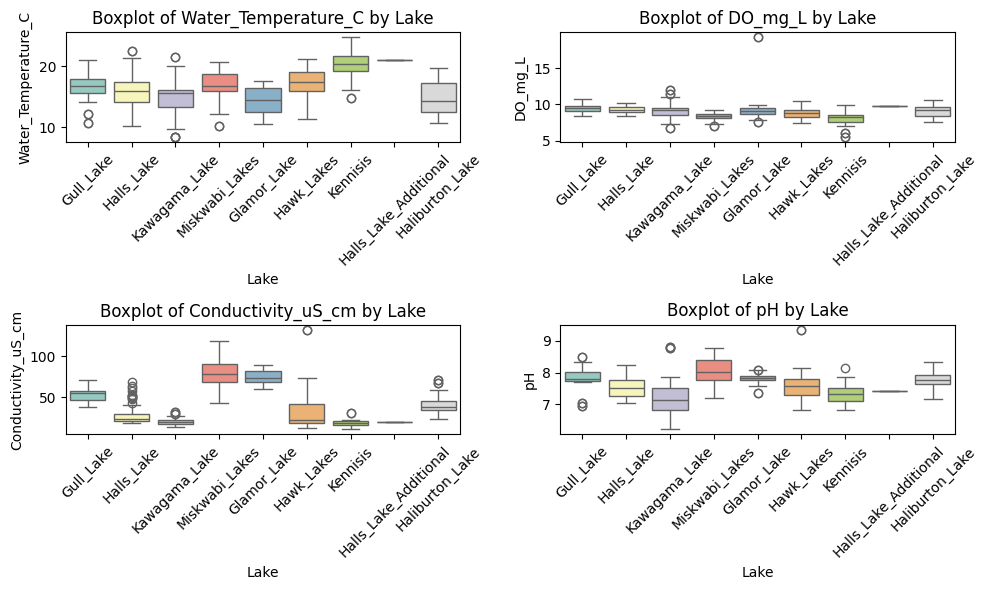

In [26]:
from skbio.stats.ordination import pcoa
import matplotlib.pyplot as plt
import seaborn as sns

# Perform PCoA
pcoa_result = pcoa(distance_matrix)

# Create a DataFrame for PCoA results
pcoa_df = pd.DataFrame(pcoa_result.samples)
pcoa_df[lake_column] = data_numeric[lake_column].values

plt.figure(figsize=(10, 6))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=data_numeric, x=lake_column, y=col, palette="Set3")
    plt.title(f"Boxplot of {col} by Lake")
    plt.xlabel("Lake")
    plt.ylabel(col)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


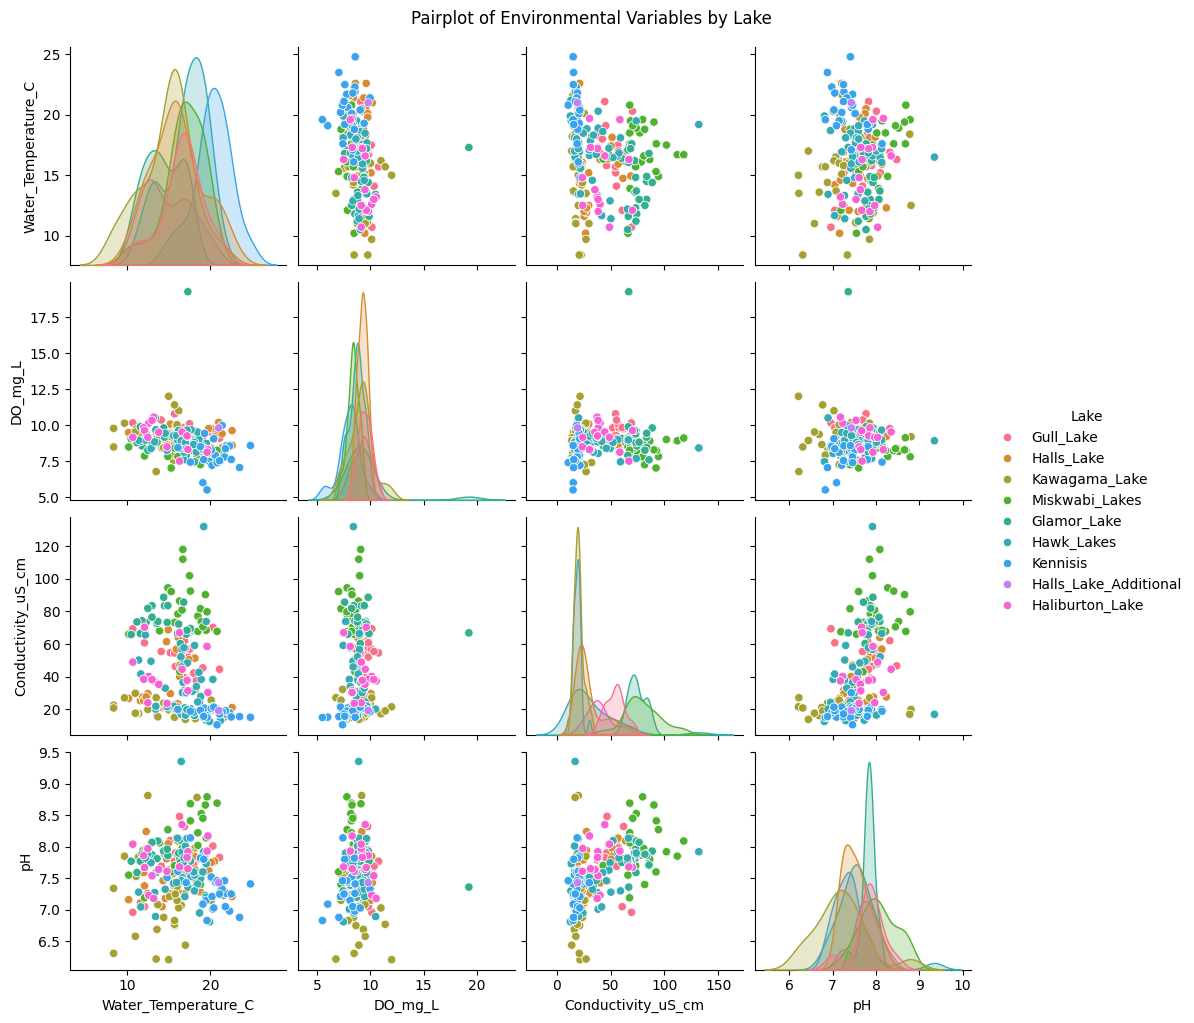

In [28]:
sns.pairplot(data=data_numeric, hue=lake_column, palette="husl", diag_kind="kde")
plt.suptitle("Pairplot of Environmental Variables by Lake", y=1.02)
plt.show()


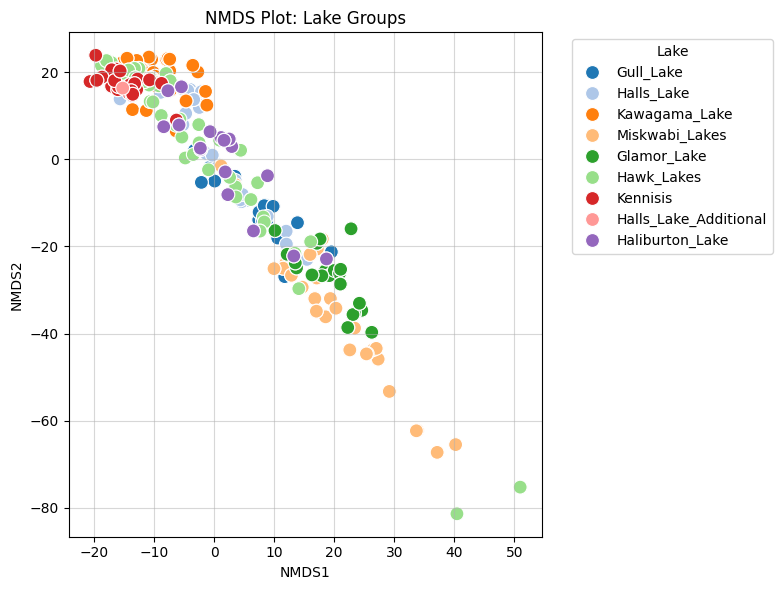

In [29]:
from sklearn.manifold import MDS

# Perform NMDS (Non-Metric Multidimensional Scaling)
nmds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
nmds_coords = nmds.fit_transform(dist_matrix_square)

# Create a DataFrame for NMDS results
nmds_df = pd.DataFrame(nmds_coords, columns=['NMDS1', 'NMDS2'])
nmds_df[lake_column] = data_numeric[lake_column].values

# Plot NMDS results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=nmds_df, x='NMDS1', y='NMDS2', hue=lake_column, palette="tab20", s=100)
plt.title("NMDS Plot: Lake Groups")
plt.xlabel("NMDS1")
plt.ylabel("NMDS2")
plt.legend(title="Lake", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()


Key Insights:
Grouping by Similarity:

Each point represents a data sample, and the closer the points are, the more similar their benthic macroinvertebrate communities are.
Lakes with points grouped together (e.g., Kennisis Lake or Halls Lake Additional) share similar ecological or environmental characteristics.
Spread of Lakes:

Lakes like Kawagama Lake and Hawk Lakes show distinct groupings that are separate from others, suggesting their benthic communities are unique compared to lakes like Halls Lake or Kennisis Lake.
Transition Zones:

Lakes such as Halls Lake and Haliburton Lake show overlap with others, indicating shared environmental factors or gradual transitions in benthic communities.
Isolated Groups:

Some lakes like Glamor Lake and Miskwabi Lakes are moderately spaced apart, indicating partial uniqueness but also some shared characteristics.
Overall Patterns:
Similar lake environments or shared influences (e.g., water quality, sediment, vegetation) tend to result in grouped points (closer proximity).
Lakes with distinct environmental conditions stand out (further apart on the plot).
This analysis can help pinpoint which lakes are ecologically similar and which are outliers, guiding targeted conservation or management strategies.

# Question 4:

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kruskal, f_oneway

# Load the data
file_path = 'Data_final.xlsx'
sheet_data = pd.read_excel(file_path)

# Add headwater classification
headwater_data = {
    "Lake": [
        "Gull_Lake", "Haliburton_Lake", "Halls_Lake", "Kawagama_Lake",
        "Kennisis_Lake", "Big_Hawk_Lake", "Little_Hawk_Lake", "Miskwabi_Lake",
        "Glamor_Lake"
    ],
    "Headwater": [
        "No", "No", "No", "No", "Yes", "Yes", "No", "Yes",
        "Yes"
    ]
}
headwater_df = pd.DataFrame(headwater_data)

# Merge headwater classification with the main data
merged_data = sheet_data.merge(headwater_df, on="Lake", how="left")

# Ensure required columns exist
required_columns = [
    "Simpson's_Diversity_Index", "DO_mg_L", "Conductivity_uS_cm", "pH", "Headwater"
]

if not all(col in merged_data.columns for col in required_columns):
    raise ValueError("One or more required columns are missing from the dataset!")

# Handle missing values
merged_data = merged_data.dropna(subset=["Simpson's_Diversity_Index", "DO_mg_L", "Conductivity_uS_cm", "pH"])

# Step 1: Chemical Conditions Analysis (DO, Conductivity, pH)
kruskal_results = {}
for chem in ['DO_mg_L', 'Conductivity_uS_cm', 'pH']:
    merged_data[f'{chem}_Category'] = pd.qcut(
        merged_data[chem], q=4, labels=["Low", "Moderate", "High", "Very High"], duplicates="drop"
    )

    # Visualization for Chemical Conditions
    sns.boxplot(data=merged_data, x=f'{chem}_Category', y="Simpson's_Diversity_Index", hue='Headwater')
    plt.title(f"Simpson's Diversity Index across {chem} Categories")
    plt.xlabel(f"{chem} Category")
    plt.ylabel("Simpson's Diversity Index")
    plt.legend(title="Headwater Status")
    plt.show()

    # Statistical Test
    chem_groups = [
        group["Simpson's_Diversity_Index"].dropna()
        for _, group in merged_data.groupby(f'{chem}_Category', observed=False)
    ]
    kruskal_test = kruskal(*chem_groups)
    kruskal_results[chem] = kruskal_test

# Print Kruskal-Wallis Test Results
for chem, test_result in kruskal_results.items():
    print(f"{chem} Kruskal-Wallis Test: H-statistic={test_result.statistic:.4f}, p-value={test_result.pvalue:.4f}")

# Step 2: Headwater vs Non-Headwater Analysis
headwater_groups = [
    merged_data[merged_data['Headwater'] == 'Yes']["Simpson's_Diversity_Index"],
    merged_data[merged_data['Headwater'] == 'No']["Simpson's_Diversity_Index"]
]
headwater_test = f_oneway(*headwater_groups)

# Print Headwater vs Non-Headwater ANOVA Results
print(f"Headwater vs Non-Headwater ANOVA: F-statistic={headwater_test.statistic:.4f}, p-value={headwater_test.pvalue:.4f}")


DO_mg_L (Dissolved Oxygen):

Kruskal-Wallis H-statistic: 6.6264 p-value: 0.0848 Interpretation: The p-value is slightly above the typical significance threshold (0.05). This suggests that there is no statistically significant difference in benthic diversity (Simpson's Diversity Index) across different categories of Dissolved Oxygen. However, the result is close to significance, indicating there might be some trends worth exploring further.

Conductivity_uS_cm:

Kruskal-Wallis H-statistic: 6.6002 p-value: 0.0858 Interpretation: Similar to DO, the p-value is not below 0.05. Therefore, we do not find statistically significant differences in diversity across conductivity levels. The differences in diversity with respect to conductivity are likely not strong enough to be conclusive.

pH:

Kruskal-Wallis H-statistic: 8.9033 p-value: 0.0306 Interpretation: The p-value here is below 0.05, indicating statistically significant differences in benthic diversity across pH categories. This suggests that pH might be a key driver of benthic diversity. The next step would involve examining which pH categories have the most variation and identifying ecological implications.

Headwater vs Non-Headwater:

ANOVA F-statistic: 0.5989 p-value: 0.4396 Interpretation: The p-value is much higher than 0.05, indicating no statistically significant difference in benthic diversity between headwater and non-headwater lakes. This suggests that whether a lake is a headwater does not strongly influence benthic diversity, at least within the available data.

Conclusion: Key Factors: Among the chemical conditions analyzed, only pH shows a significant relationship with benthic diversity. This suggests that pH might play an important role in shaping the benthic community. The other parameters (DO and Conductivity) do not show strong evidence of influencing diversity in this dataset.

Headwater vs Non-Headwater: No significant differences were observed, implying that benthic diversity patterns are relatively consistent between headwater and non-headwater lakes.

1st Plot: Explanation of the Plot: This box plot shows how Simpson's Diversity Index (a measure of benthic diversity) varies across different categories of dissolved oxygen (DO) levels (DO_mg_L), with a comparison between headwater and non-headwater lakes.

Diversity Index and DO Levels:

Simpson's Diversity Index generally remains high (closer to 1) across all categories of dissolved oxygen, though there is variability. The "Low" DO category shows slightly wider variation in diversity compared to higher DO categories. Headwater vs. Non-Headwater Status:

Headwater lakes (orange boxes) tend to have slightly lower median diversity values compared to non-headwater lakes (blue boxes) in some categories, especially in "Very High" DO levels. The spread (interquartile range) is larger in headwater lakes for higher DO categories, indicating more variability in these systems. Outliers:

There are several low-diversity outliers in all DO categories, particularly in headwater lakes, suggesting some benthic communities in these systems are less diverse despite high oxygen levels. Insights and Patterns: Pattern: Benthic Diversity and DO Levels

In both headwater and non-headwater lakes, diversity generally increases from "Low" to "Moderate" DO levels but plateaus at "High" and "Very High" levels. This suggests that extremely high dissolved oxygen may not necessarily correlate with higher benthic diversity. Other factors, such as habitat complexity or nutrient availability, may play a role. Headwater vs. Non-Headwater:

Non-headwater lakes generally exhibit slightly higher benthic diversity than headwater lakes across most DO categories. This could be due to differences in nutrient inflows, sediment types, or riparian vegetation affecting benthic habitats. Riparian Influence:

Riparian vegetation and sediment input may contribute to the observed variability, particularly in headwater systems where benthic diversity appears more sensitive to environmental changes (as seen in the wider range of the box plots). Summary of a Key Pattern: Headwater lakes display greater variability in benthic diversity across higher dissolved oxygen levels, likely due to localized environmental factors like sediment and nutrient inputs, whereas non-headwater lakes exhibit more consistent diversity trends.

Plot 2: This plot shows the relationship between Simpson's Diversity Index (a measure of benthic species diversity) and categories of electrical conductivity (uS/cm) in aquatic environments. Conductivity is a chemical parameter that indicates the concentration of dissolved ions in water, often linked to riparian (shoreline) zone and catchment area characteristics.

Here’s how to interpret it:

X-axis (Conductivity Categories):

The conductivity categories (Low, Moderate, High, Very High) represent varying chemical conditions. As conductivity increases, it may reflect anthropogenic impacts, nutrient inputs, or natural geological differences. Y-axis (Simpson's Diversity Index):

Higher values of this index indicate greater benthic species diversity, while lower values indicate lower diversity. Headwater Status (Legend):

Two groups are distinguished: "Headwater Lakes" (Yes) and non-headwater lakes (No). Headwater lakes are upstream systems often more isolated and potentially less influenced by downstream inputs. Key Observations and Patterns: Diversity vs. Conductivity:

Across all conductivity categories, there is a spread in Simpson's Diversity Index, with diversity generally being moderate to high. In "Very High" conductivity zones, the range of diversity appears less pronounced, suggesting that extreme chemical conditions might limit benthic diversity.

Headwater vs. Non-Headwater Patterns:

For "Moderate" and "High" conductivity, headwater lakes (orange) often show slightly lower median diversity compared to non-headwater lakes (blue). In "Low" conductivity, diversity patterns for headwater and non-headwater lakes are fairly similar, with overlapping interquartile ranges. One distinct pattern: In "Very High" conductivity zones, non-headwater lakes seem to maintain a wider spread of diversity compared to headwater lakes, which show a more constrained range.

Interpretation: Riparian Zone Influence: Differences in conductivity likely stem from variations in riparian zones, where nutrient-rich or disturbed zones may lead to "Very High" conductivity and reduced diversity. Chemical Sensitivity in Headwaters: Headwater lakes may be more sensitive to chemical changes, potentially due to smaller watershed areas and limited buffering capacity.

Plot 3: Explanation of the Plot This boxplot visualizes Simpson's Diversity Index (a measure of species diversity, where higher values indicate greater diversity) across different pH categories (Low, Moderate, High, Very High). The categories are further divided based on Headwater Status (Yes or No), indicating whether a site is located in a headwater lake.

Key Observations: Variation Across pH Categories:

Simpson's Diversity Index generally shows consistent median values across all pH categories, with no strong trend indicating that pH significantly alters diversity. Some outliers exist in lower pH conditions, particularly in the Low category, indicating reduced diversity at specific sites. Headwater vs. Non-Headwater:

For each pH category, headwater lakes (orange) and non-headwater lakes (blue) have similar median diversity values, suggesting that headwater status does not strongly differentiate diversity in this dataset. Non-headwater lakes tend to have slightly higher diversity in the Moderate and Very High pH categories. Spread and Outliers:

The spread of diversity values increases at higher pH levels (Moderate to Very High categories), with greater variability observed in non-headwater lakes. More extreme low-diversity outliers appear at Low and Moderate pH levels, particularly in non-headwater sites. Relevance to Riparian Zones and Chemical Conditions: The relationship between pH and diversity could reflect the buffering capacity of riparian zones and their influence on chemical stability. Riparian zones with better vegetation and nutrient control may maintain more stable pH conditions, potentially supporting higher diversity.

Headwater lakes are often more sensitive to chemical changes due to their smaller watershed size and limited buffering capacity. However, this plot suggests that the effect of pH on diversity might not differ significantly between headwater and non-headwater systems. Key Pattern: Non-headwater lakes exhibit slightly higher Simpson's Diversity Index at higher pH levels (Moderate to Very High), suggesting that pH stability or favorable chemical conditions might promote diversity more effectively in these environments.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plot for Conductivity
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

sns.lmplot(
    data=merged_data,
    x='Conductivity_uS_cm',
    y="Simpson's_Diversity_Index",
    hue='Headwater',
    palette='muted',
    height=6,
    aspect=1.5,
    markers=["o", "s"],
    scatter_kws={'alpha': 0.7}
)

plt.title("Simpson's Diversity Index vs Conductivity", fontsize=14)
plt.xlabel("Conductivity (µS/cm)", fontsize=12)
plt.ylabel("Simpson's Diversity Index", fontsize=12)
plt.tight_layout()
plt.show()

# Scatter plot for DO
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

sns.lmplot(
    data=merged_data,
    x='DO_mg_L',
    y="Simpson's_Diversity_Index",
    hue='Headwater',
    palette='muted',
    height=6,
    aspect=1.5,
    markers=["o", "s"],
    scatter_kws={'alpha': 0.7}
)

plt.title("Simpson's Diversity Index vs Dissolved Oxygen (DO)", fontsize=14)
plt.xlabel("Dissolved Oxygen (mg/L)", fontsize=12)
plt.ylabel("Simpson's Diversity Index", fontsize=12)
plt.tight_layout()
plt.show()


PLOT FOR DO Non-headwater Lakes (Blue):

The regression line for non-headwater lakes shows a slight positive trend. This indicates that as dissolved oxygen increases, benthic diversity tends to increase slightly. The trend suggests that more oxygen-rich environments in non-headwater lakes may support a greater variety of benthic organisms.

Headwater Lakes (Orange):

For headwater lakes, the regression line shows a slight negative slope. This suggests that in these systems, increasing dissolved oxygen is associated with a small decrease in benthic diversity.

However, the confidence interval (shaded region) is broad, indicating high variability and uncertainty in this trend.

Variability: There is substantial scatter in both groups, particularly at mid-range DO values (~8–12 mg/L), suggesting that other factors (e.g., nutrient availability, temperature, or habitat complexity) are influencing benthic diversity alongside dissolved oxygen.

Riparian Zones and Chemical Conditions: Riparian Influence on Dissolved Oxygen:

Headwater lakes are often located in pristine riparian zones with high canopy cover and cooler temperatures, conditions that typically support higher DO levels.

Non-headwater lakes, influenced by surrounding land use (e.g., agriculture or urbanization), may experience warmer temperatures and nutrient loading, leading to lower DO levels.

Diversity and Oxygen Dynamics:

In headwater lakes, benthic species adapted to stable conditions may dominate, leading to limited diversity changes across a range of DO levels. In non-headwater lakes, the slight positive trend suggests that oxygen-rich conditions might mitigate stressors (e.g., eutrophication) and support more diverse benthic communities.

One Particular Pattern: In non-headwater lakes (blue), benthic diversity increases slightly with rising dissolved oxygen, likely because DO supports more aerobic species. This trend contrasts with headwater lakes, where diversity appears to remain stable or slightly decline at higher DO levels, potentially due to differences in species composition or habitat constraints.

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plot for pH
sns.set_style("whitegrid")

sns.lmplot(
    data=merged_data,
    x='pH',
    y="Simpson's_Diversity_Index",
    hue='Headwater',
    palette='muted',
    height=6,
    aspect=1.5,
    markers=["o", "s"],
    scatter_kws={'alpha': 0.7}
)

plt.title("Simpson's Diversity Index vs pH", fontsize=14)
plt.xlabel("pH", fontsize=12)
plt.ylabel("Simpson's Diversity Index", fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set style for consistent visualization
sns.set_style("whitegrid")

# Create a figure with subplots
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Scatter plot for pH
sns.regplot(
    data=merged_data,
    x='pH',
    y="Simpson's_Diversity_Index",
    ax=ax[0],
    scatter_kws={'alpha': 0.7, 's': 50},
    line_kws={'color': 'blue'},
    color='teal'
)
ax[0].set_title("Simpson's Diversity Index vs pH", fontsize=14)
ax[0].set_xlabel("pH", fontsize=12)
ax[0].set_ylabel("Simpson's Diversity Index", fontsize=12)

# Scatter plot for Conductivity
sns.regplot(
    data=merged_data,
    x='Conductivity_uS_cm',
    y="Simpson's_Diversity_Index",
    ax=ax[1],
    scatter_kws={'alpha': 0.7, 's': 50},
    line_kws={'color': 'green'},
    color='purple'
)
ax[1].set_title("Simpson's Diversity Index vs Conductivity", fontsize=14)
ax[1].set_xlabel("Conductivity (µS/cm)", fontsize=12)
ax[1].set_ylabel("")

# Adjust layout
plt.tight_layout()
plt.show()


Interpretation of Each Plot:

Left Panel: Simpson's Diversity Index vs. pH X-axis: pH of the water, representing acidity/alkalinity. Lower pH values indicate more acidic conditions, while higher values indicate more basic conditions. Y-axis: Simpson's Diversity Index, where higher values reflect greater benthic diversity. Pattern Observed: There is a weak negative trend between pH and Simpson's Diversity Index (slight downward slope of the regression line). This suggests that as pH increases, diversity tends to decrease slightly. However, the relationship is not strong, as the points are widely scattered around the regression line. The shaded region indicates uncertainty or variability in this trend.
Right Panel: Simpson's Diversity Index vs. Conductivity X-axis: Conductivity (µS/cm), representing ion concentration in the water. Higher conductivity usually indicates increased nutrient or pollutant levels. Y-axis: Simpson's Diversity Index. Pattern Observed: There is an even weaker negative trend between conductivity and Simpson's Diversity Index (almost flat regression line). This suggests that diversity is only slightly affected as conductivity increases. The points show considerable scatter, indicating a weak or minimal correlation.
Insights on Riparian Zones, Chemical Conditions, and Headwater Lakes: Riparian Zones:

Riparian zone characteristics, such as vegetation cover and disturbance, influence pH and conductivity by affecting nutrient inputs and buffering capacity. The weak trends suggest that benthic diversity is moderately resilient to changes in these chemical conditions but may decline in highly disturbed or nutrient-rich riparian zones.

Chemical Conditions:

The slight negative relationships suggest that extreme chemical conditions (e.g., high pH or high conductivity) may mildly reduce diversity. This could occur because fewer species are adapted to tolerate such conditions.

Headwater vs. Non-Headwater Patterns:

Although headwater lakes are not explicitly shown here, they are generally expected to have lower conductivity (due to limited external inputs) and pH closer to neutral.

If the data were grouped by headwater status, headwater lakes might exhibit stronger patterns of diversity resilience due to their isolation and lower anthropogenic influence.

One Specific Pattern: The left panel suggests that benthic diversity may be slightly higher in water bodies with near-neutral pH (around 7.0–7.5) compared to more alkaline systems (pH > 8.0). This could indicate that benthic species in these systems prefer stable, neutral chemical conditions.

In [ ]:
import pandas as pd
import folium

# Load the dataset
file_path = "cleaned_dataset.xlsx"
data = pd.read_excel(file_path)

# Columns to use for the map
latitude_col = "Latitude"
longitude_col = "Longitude"
site_code_col = "Site_Code"
lake_col = "Lakes"

# Predefined colors for lakes (distinct colors for up to 10 lakes; extend as needed)
predefined_colors = [
    "red", "green", "purple", "orange", "darkblue", "darkgreen",
    "cadetblue", "pink", "lightgray", "black"
]

# Map each lake to a color
unique_lakes = data[lake_col].unique()
lake_colors = {lake: predefined_colors[i % len(predefined_colors)] for i, lake in enumerate(unique_lakes)}

# Create a map centered around the mean coordinates
center_lat = data[latitude_col].mean()
center_lon = data[longitude_col].mean()

# Corrected Stamen Terrain tile with attribution
tile_attribution = 'Map tiles by Stamen Design, under CC BY 3.0. Data by OpenStreetMap, under ODbL.'

map = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=10,
    tiles="Stamen Terrain",
    attr=tile_attribution
)

# Add markers for each site with decorative icons
for _, row in data.iterrows():
    lake_name = row[lake_col]
    color = lake_colors[lake_name]  # Get the color for this lake

    # Add a custom marker with a unique color and icon
    folium.Marker(
        location=[row[latitude_col], row[longitude_col]],
        popup=f"<b>Lake:</b> {row[lake_col]}<br><b>Site Code:</b> {row[site_code_col]}<br><b>Date:</b> {row['Date']}<br><b>Time:</b> {row['Time']}",
        tooltip=row[site_code_col],
        icon=folium.Icon(color=color, icon='cloud', icon_color='white', prefix='fa'),  # Custom icon with white color
    ).add_to(map)

# Add a decorative legend to the bottom-right corner
legend_html = """
<div style="position: fixed;
            bottom: 30px; right: 30px; width: 220px; height: auto;
            background-color: rgba(255, 255, 255, 0.8); z-index:9999; padding: 15px;
            border: 2px solid #444; border-radius: 10px; box-shadow: 0px 4px 6px rgba(0,0,0,0.2);">
    <b style="font-size: 16px;">Lake Legend</b><br>
    <hr style="border: 1px solid #ccc;">
"""
for lake, color in lake_colors.items():
    legend_html += f'''
        <i style="background: {color}; width: 15px; height: 15px; display: inline-block;
                   border-radius: 50%; margin-right: 10px;"></i>{lake}<br>
    '''
legend_html += "</div>"

map.get_root().html.add_child(folium.Element(legend_html))

# Save the map to an HTML file
output_path = "decorative_map_with_legend.html"
map.save(output_path)

print(f"Decorative map with legend saved to {output_path}")9
